# **Afghanistan War Analysis** 
- **Title**: Afghanistan Security during 2004 Election
- **Period**: 2001 - 2006
  
<img src="https://i0.wp.com/fightersweep.com/wp-content/uploads/2017/05/ac-130-gunship_flares.jpg?fit=2700%2C1517&ssl=1" width="1050px"> 

In [8]:
from wikipedia import search, WikipediaPage
import pandas as pd 
import numpy as np 
from urllib import request as curl 
from bs4 import BeautifulSoup
import os 
import json 
import re 
import boto3 
import multiprocessing as mp 
import math 
import pymssql 
import zipfile
import warnings 
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics 
import tensorflow as tf 

import plotly.express as px 
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
import seaborn as sns 
import squarify as sq 

from typing import List, Dict 

DATASET_PATH: str = os.path.join(os.path.expanduser("~/"), "Developments/Humanitarian/datasets")
pd.options.display.max_columns = 70
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

# **Helper Functions** 

In [2]:
def download_dataset(file_name: str):

    url: str = f"http://data.gdeltproject.org/events/{file_name}"
    try: 
        resp: str = curl.urlopen(url=url).read()

        # save the raw data in tmp dir 
        with open(f"/tmp/{file_name}", "wb") as f: 
            f.write(resp)
        f.close()

        # extract dataset 
        zipfile.ZipFile(file=os.path.join("/tmp", file_name) ).extractall(path=DATASET_PATH )
        
    except ConnectionError as e: 
        raise ConnectionError(f"[ ERROR ] Unable to connect to the following url: {url}. Please check the file name again !!!") from e 


# **GDELT Raw Data** 

In [12]:
gdelt_link: str = "http://data.gdeltproject.org/events/index.html" 
resp: bytes = curl.urlopen(url=gdelt_link).read()
soup = BeautifulSoup(resp)

pool = mp.Pool(processes=mp.cpu_count())

for link in soup.find_all("a"): 
    year: str = link.text[:4]
    if 'zip' in link.text and (year.isdigit() and int(year,10) in range(2001,2006) ):
        print("[ \033[92m+\033[0m ] downloading data --> %s" % (link))
        pool.apply_async(download_dataset, (link.text ,))

pool.close()
pool.join() 

[ + ] downloading data --> <a href="2005.zip">2005.zip</a>
[ + ] downloading data --> <a href="2004.zip">2004.zip</a>
[ + ] downloading data --> <a href="2003.zip">2003.zip</a>
[ + ] downloading data --> <a href="2002.zip">2002.zip</a>
[ + ] downloading data --> <a href="2001.zip">2001.zip</a>


## **Additional Data: (`PRIO.org`)** 

In [3]:
conflict_df: 'DataFrame' = pd.read_csv("/home/ubuntu/Developments/Humanitarian/datasets/ConflictRecurrenceDatabase.csv")
conflict_df.query("country == 'Afghanistan' ").head(5)

,conflict_new_id,conflict_name,dyad_new_id,dyad_name,type_of_violence,active_year,country,conflict_dyad,dyad_ep_start,dyad_ep_end,dyad_recurrence_date,dyad_ep_id,conf_ep_start,conf_ep_end,conf_recurrence_date,conf_ep_id,location,incompatibility,territory_name,type_of_conflict,region,conf_subid,conf_recurrence,confactor_recurrence,dyad_recurrence,factions,link_type_1,link_id_1,link_type_2,link_id_2,link_type_3,link_id_3,link_type_4,link_id_4,link_type_5,link_id_5,link_type_6,link_id_6,dyad_recurrence_years,conf_recurrence_years,conf_ep_low,conf_ep_best,conf_ep_high,dyad_ep_low,dyad_ep_best,dyad_ep_high,conf_ep_freq,dyad_ep_freq,cont_dyad,cont_conf
285,333.0,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,1.0,1,Afghanistan,333_724,1/7/1989,2/29/1992,9/28/1996,333_724_1992,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,1.0,0.0,0.0,5.0,NaN,4.0,333_736_2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,185567.0,201053.0,261121.0,2258.0,2546.0,3396.0,25936.0,75.0,0.0,0.0
286,333.0,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,1.0,1,Afghanistan,333_724,9/28/1996,10/10/1996,NaN,333_724_1996,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,2.0,0.0,0.0,3.0,NaN,4.0,333_736_2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185567.0,201053.0,261121.0,314.0,314.0,314.0,25936.0,6.0,1.0,0.0
287,333.0,Afghanistan: Government,726,Government of Afghanistan - Hizb-i Islami-yi A...,1.0,1,Afghanistan,333_726,7/23/1989,8/27/1995,9/5/2002,333_726_1995,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,185567.0,201053.0,261121.0,8947.0,9144.0,15113.0,25936.0,195.0,0.0,0.0
288,333.0,Afghanistan: Government,726,Government of Afghanistan - Hizb-i Islami-yi A...,1.0,1,Afghanistan,333_726,9/5/2002,12/5/2003,5/16/2006,333_726_2003,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,3.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,185567.0,201053.0,261121.0,62.0,62.0,75.0,25936.0,8.0,0.0,0.0
289,333.0,Afghanistan: Government,726,Government of Afghanistan - Hizb-i Islami-yi A...,1.0,1,Afghanistan,333_726,5/16/2006,12/8/2006,3/11/2008,333_726_2006,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,3.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,185567.0,201053.0,261121.0,40.0,40.0,60.0,25936.0,9.0,0.0,0.0


## **Global Terrorism Database**
- Country: `Afghanistan` (1973 - 2020)

In [3]:
gdb: 'DataFrame' = pd.read_excel(os.path.join(DATASET_PATH, "globalterrorismdb_0522dist.xlsx") )
afghan_df: 'DataFrame' = gdb.query("country_txt == 'Afghanistan' ")
afghan_df['event_date'] = pd.to_datetime(afghan_df.apply(lambda row: "%s-%s-%s" %  (row.iyear, row.imonth, row.iday if row.iday > 0 else 1) , axis=1).tolist())

afghan_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date
1862,197305010002,1973,5,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,0,0,9,Unknown,NaN,NaN,NaN,NaN,6,...,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1973-05-01
7626,197902140010,1979,2,14,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,...,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,4.0,Hostage(s) killed (not during rescue attempt),1.0,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1979-02-14
9155,197908270005,1979,8,27,NaN,0,NaT,4,Afghanistan,6,South Asia,Ghazni,Ghazni,33.542622,68.415329,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,19,...,0.0,NaN,NaN,1,3.0,Minor (likely < $1 million),30000.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN,1979-08-27
9217,197909090001,1979,9,9,NaN,0,NaT,4,Afghanistan,6,South Asia,Herat,Herat,34.346722,62.197315,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,18,...,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,-9,-9,NaN,1979-09-09
31128,198705310003,1987,5,31,NaN,0,NaT,4,Afghanistan,6,South Asia,Unknown,Unknown,NaN,NaN,5.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,8,Unarmed Assault,NaN,NaN,NaN,NaN,14,...,2.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBRN Global Chronology,0,0,0,0,NaN,1987-05-31


## **Dataset Events in Afghanistan (`2001 - 2006`)** 

In [18]:
current_event: str = os.path.join(DATASET_PATH, "2001_2006_events.xlsx")
salvo_df: 'DataFrame' = afghan_df.query(" iyear >= 2001 and iyear <= 2006 ")
salvo_df.to_excel(current_event )

# save current event 
s3_bucket = boto3.client('s3')
s3_bucket.upload_file(Filename=current_event, Bucket="worldevents", Key=f"Afghanistan/{os.path.basename(current_event)}")

salvo_df.head(5)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date
71689,200101070007,2001,1,7,NaN,1,2001-01-10,4,Afghanistan,6,South Asia,Bamyan,Yakawlang,34.733333,66.966667,1.0,0,Yakawlang town and the surrounding district,1/7/2001: Taliban militia regained control of ...,1,1,1,0,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,14,...,NaN,0.0,0.0,-9,NaN,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sources provide different accounts of the numb...,"""Taliban recapture central Afghan district,"" A...","""Taleban killed hundreds of Afghans - reports,...","""Afghanistan - Taleban accused of mass killing...",UMD Schmid 2012,0,0,0,0,NaN,2001-01-07
71772,200101220006,2001,1,22,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,Near a United Nations building and the unoccup...,1/22/2001: A bomb exploded near the unoccupied...,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,"A cement wall was damaged, as was a tree",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Bomb explodes near Iranian Embassy, UN buildi...","""Blasts shake Afghan capital,"" Agence France-P...","""Fifth explosion in week hits Afghan capital,""...",UMD Schmid 2012,-9,-9,1,1,NaN,2001-01-22
71822,200102010001,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,Near the ministry of education in downtown Kabul,2/1/2001: A bomb exploded near the Ministry of...,1,1,1,0,NaN,NaN,1.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,2,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,Windows in near-by stores were broken in the e...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01
71825,200102010005,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,In front of the tribal affairs ministry in dow...,2/1/2001: A bomb hidden in a sewer drain explo...,1,1,1,0,NaN,NaN,1.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,2,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,A brick wall in front of the ministry was dama...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01
71826,200102010006,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,The compound of the Kabul Hotel in downtown Kabul,2/1/2001: A bomb exploded in compound of the T...,1,1,1,0,NaN,NaN,1.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,1,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,Several windows were broken in the explosion,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01


## **Current Events** 

In [2]:
seasons: Dict = {'Summer': range(6,9), 
                 'Autumn': range(9,12), 
                 'Winter': [12,1,2],
                 'Spring': range(3,7) } 

current_event: str = os.path.join(DATASET_PATH, "2001_2006_events.xlsx")
salvo_df: 'DataFrame' = pd.read_excel(current_event)
salvo_df['Month'] = salvo_df['event_date'].apply(lambda row: row.month_name())
salvo_df['DayName'] = salvo_df['event_date'].apply(lambda row: row.day_name())
salvo_df['gname_mapped'] = pd.factorize( salvo_df['gname'])[0] 
salvo_df['season'] = salvo_df['imonth'].apply(lambda row: 'Summer' if row in seasons.get('Summer') else 'Autumn' if row in seasons.get('Autumn') else 'Spring' if row in seasons.get('Spring') else 'Winter')

## **Afghanistan War Timeline**

In [30]:
resp: WikipediaPage = WikipediaPage(search("War in Afghanistan" )[1])
afghan_war_timeline: 'DataFrame' = pd.DataFrame( [ {'Index': re.sub("=", "", row).strip().split(":")[0], 'Timeline':  re.sub("=", "", row).strip().split(":")[1].title() } for row in resp.content.split("\n")   if "==" in row and re.findall(r"[0-9]{1,}\–", row) ] ).set_index('Index')
afghan_war_timeline

,Timeline
Index,
2001–2002,Invasion And Early Operations
2003–2005,Taliban Resurgence
2006–2009,Escalating War And Nato Build-Up
2010–2013,Coalition Offensives And Strategic Agreements
2014–2017,Withdrawal And Increase Of Insurgency
2018–2020,Peace Overtures
2020–2021,Us Withdrawal


In [31]:
secret: 'SecretManagers' = boto3.client('secretsmanager')
server,user,password = list(json.loads(secret.get_secret_value(SecretId='afghan_project').get('SecretString')).values()) 
con: 'MSSQL' = pymssql.connect(server=server, user=user, password=password)
con.autocommit(True)
cursor = con.cursor() 

# Tbl: AfghanWar
# cursor.execute("CREATE DATABASE AfghanWar" )
# con.commit() 

## **Afghanistan: Distribution of Wounded and Fatailities**

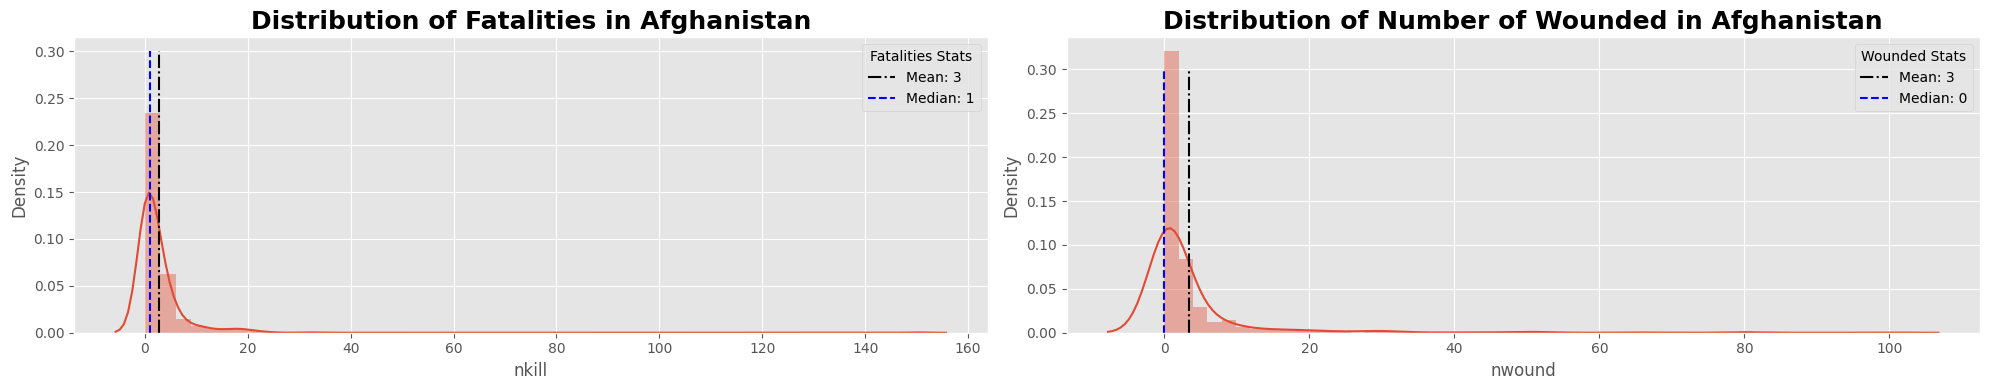

In [68]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,2,1) 

# Fatalities
sns.distplot(salvo_df['nkill'], ax=ax)
ax.set_title("Distribution of Fatalities in Afghanistan", fontweight='bold', fontsize=18)
mean_nkill: float = salvo_df['nkill'].mean() 
median_nkill: float = salvo_df['nkill'].median() 
ax.vlines(x=mean_nkill, ymin=0.0, ymax=0.3, label=f"Mean: {round(mean_nkill)}", linestyles="-.", color='black')
ax.vlines(x=median_nkill, ymin=0.0, ymax=0.3, label=f"Median: {math.trunc(median_nkill)}", linestyles="--", color='blue')
ax.legend(title="Fatalities Stats")

# Wounded
ax = fig.add_subplot(1,2,2) 
sns.distplot(salvo_df['nwound'], ax=ax)
ax.set_title("Distribution of Number of Wounded in Afghanistan", fontweight='bold', fontsize=18)
mean_nwound: float = salvo_df['nwound'].mean() 
median_nwound: float = salvo_df['nwound'].median() 
ax.vlines(x=mean_nwound, ymin=0.0, ymax=0.3, label=f"Mean: {round(mean_nwound)}", linestyles="-.", color='black')
ax.vlines(x=median_nwound, ymin=0.0, ymax=0.3, label=f"Median: {math.trunc(median_nwound)}", linestyles="--", color='blue')
ax.legend(title="Wounded Stats")

plt.tight_layout()

## **Events Happening in Afghanistan during (2001 - 2006)**
Explore the following: 
- Targeted Individual or groups during the incidents 
- Methods used during the attacked
- Places/Infrastructures targeted by the perpetrators 

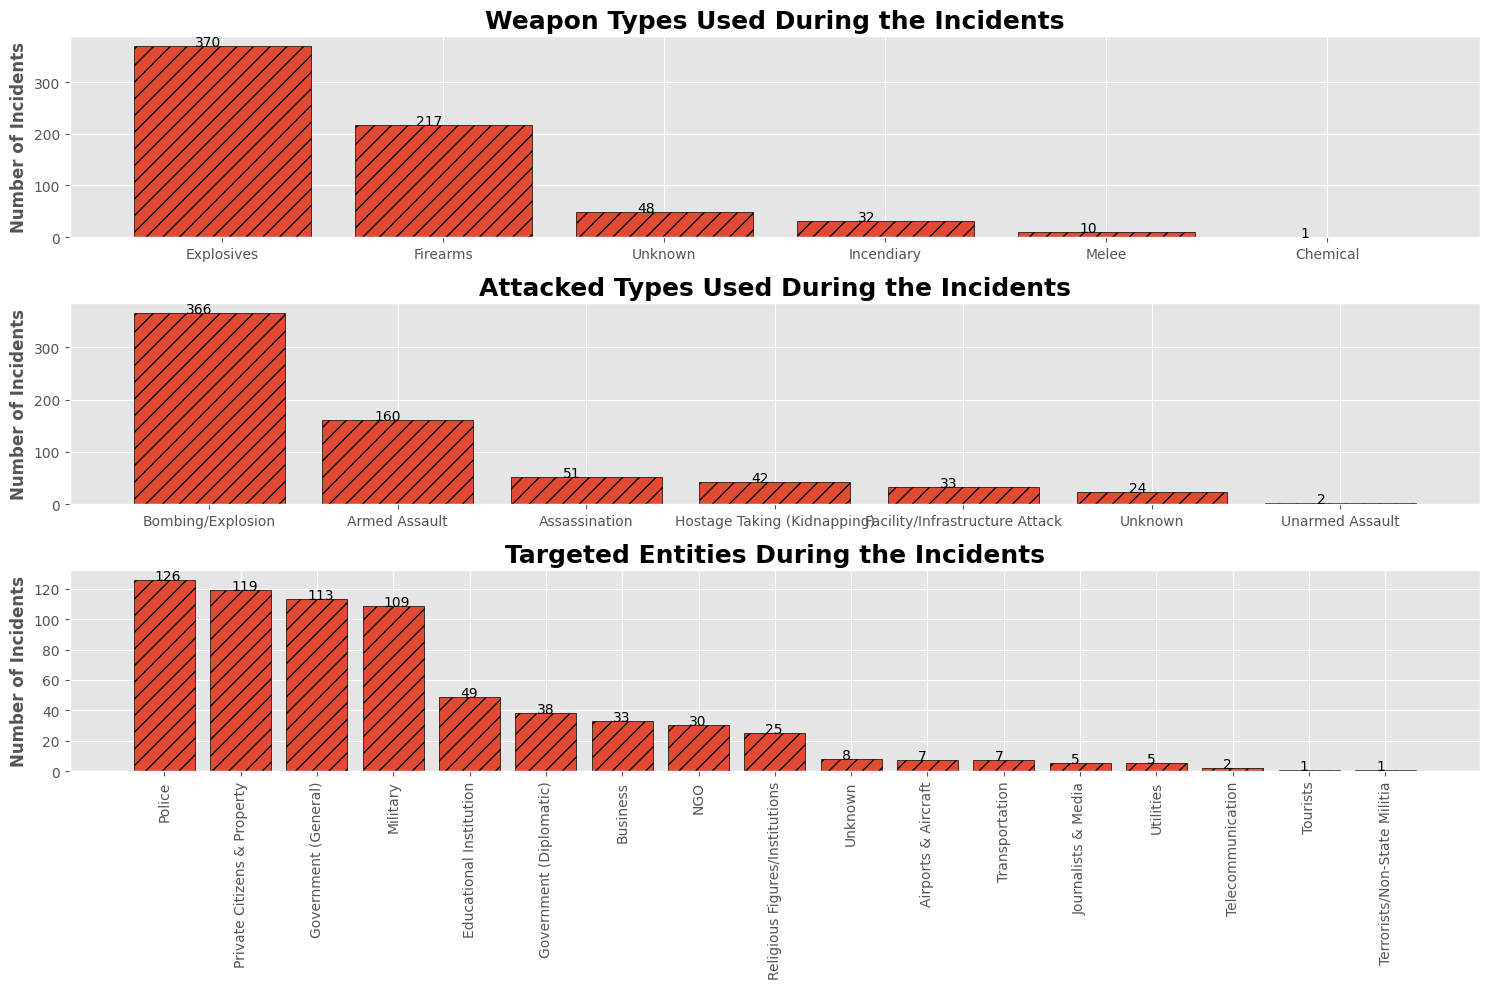

In [67]:
fig = plt.figure(figsize=(15,10))
titles: List[str] = ["Weapon Types Used During the Incidents", "Attacked Types Used During the Incidents", "Targeted Entities During the Incidents" ]
for index,col in enumerate(['weaptype1_txt', 'attacktype1_txt','targtype1_txt' ],1):
    ax = fig.add_subplot(3,1,index) 
    events, freqs = zip(*salvo_df[col].value_counts().to_dict().items())
    ax.bar(x=list(events), height=list(freqs), edgecolor='k', hatch="//")
    title: str = "%s" % ( re.sub("type1_txt", "", col).title() )
    ax.set_title( titles[index - 1 ]  , fontweight='bold', fontsize=18) 
    ax.set_ylabel("Number of Incidents", fontweight='bold')
    if index == 3: 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 

    for i,n_event in enumerate(freqs): 
        ax.annotate(text=f"{n_event}", xy=(i - 0.123, n_event) ) 
        
plt.tight_layout() 

## **Histogram: Type of Attacks**

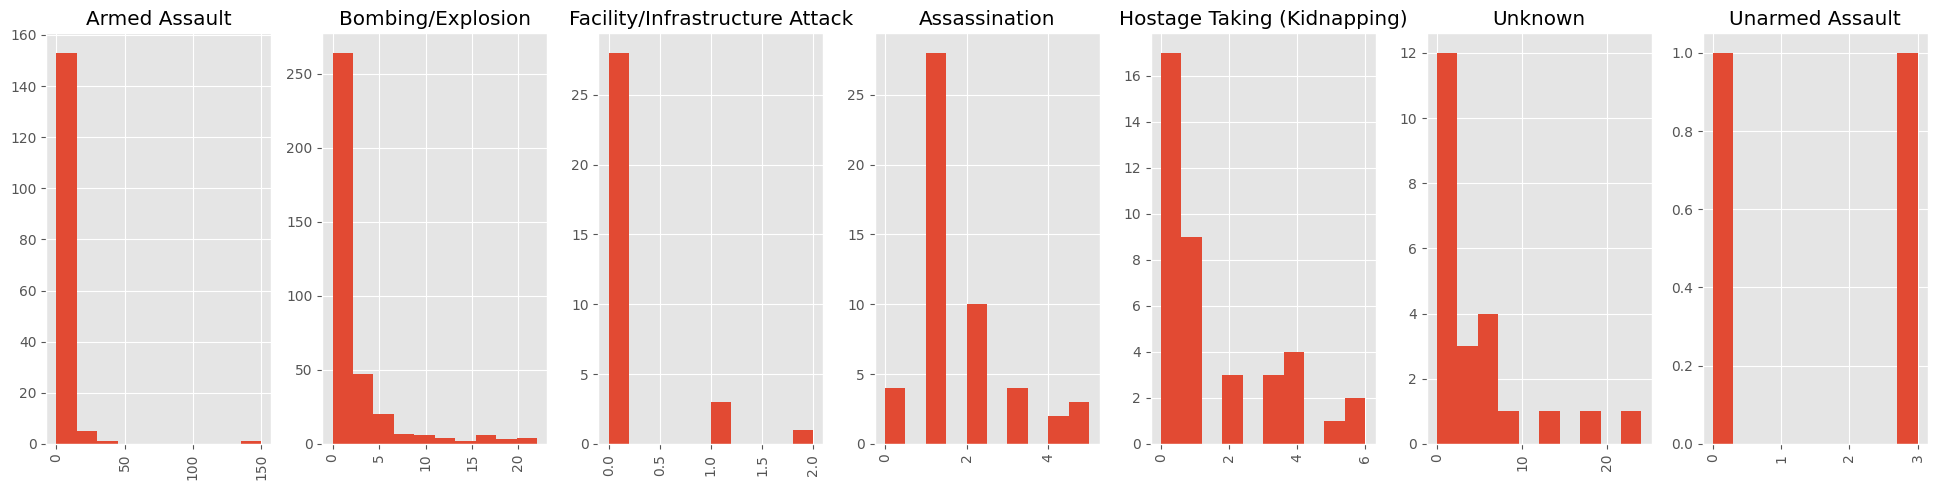

In [84]:
fig = plt.figure(figsize=(25,5)) 
for index,event in enumerate(salvo_df['attacktype1_txt'].unique(), 1): 
    ax = fig.add_subplot(1,9,index) 
    salvo_df.query(f"attacktype1_txt == '{event}' ").hist(by='attacktype1_txt', column='nkill', ax=ax)

plt.tight_layout() 

## **Boxplot: Main Incidents** 

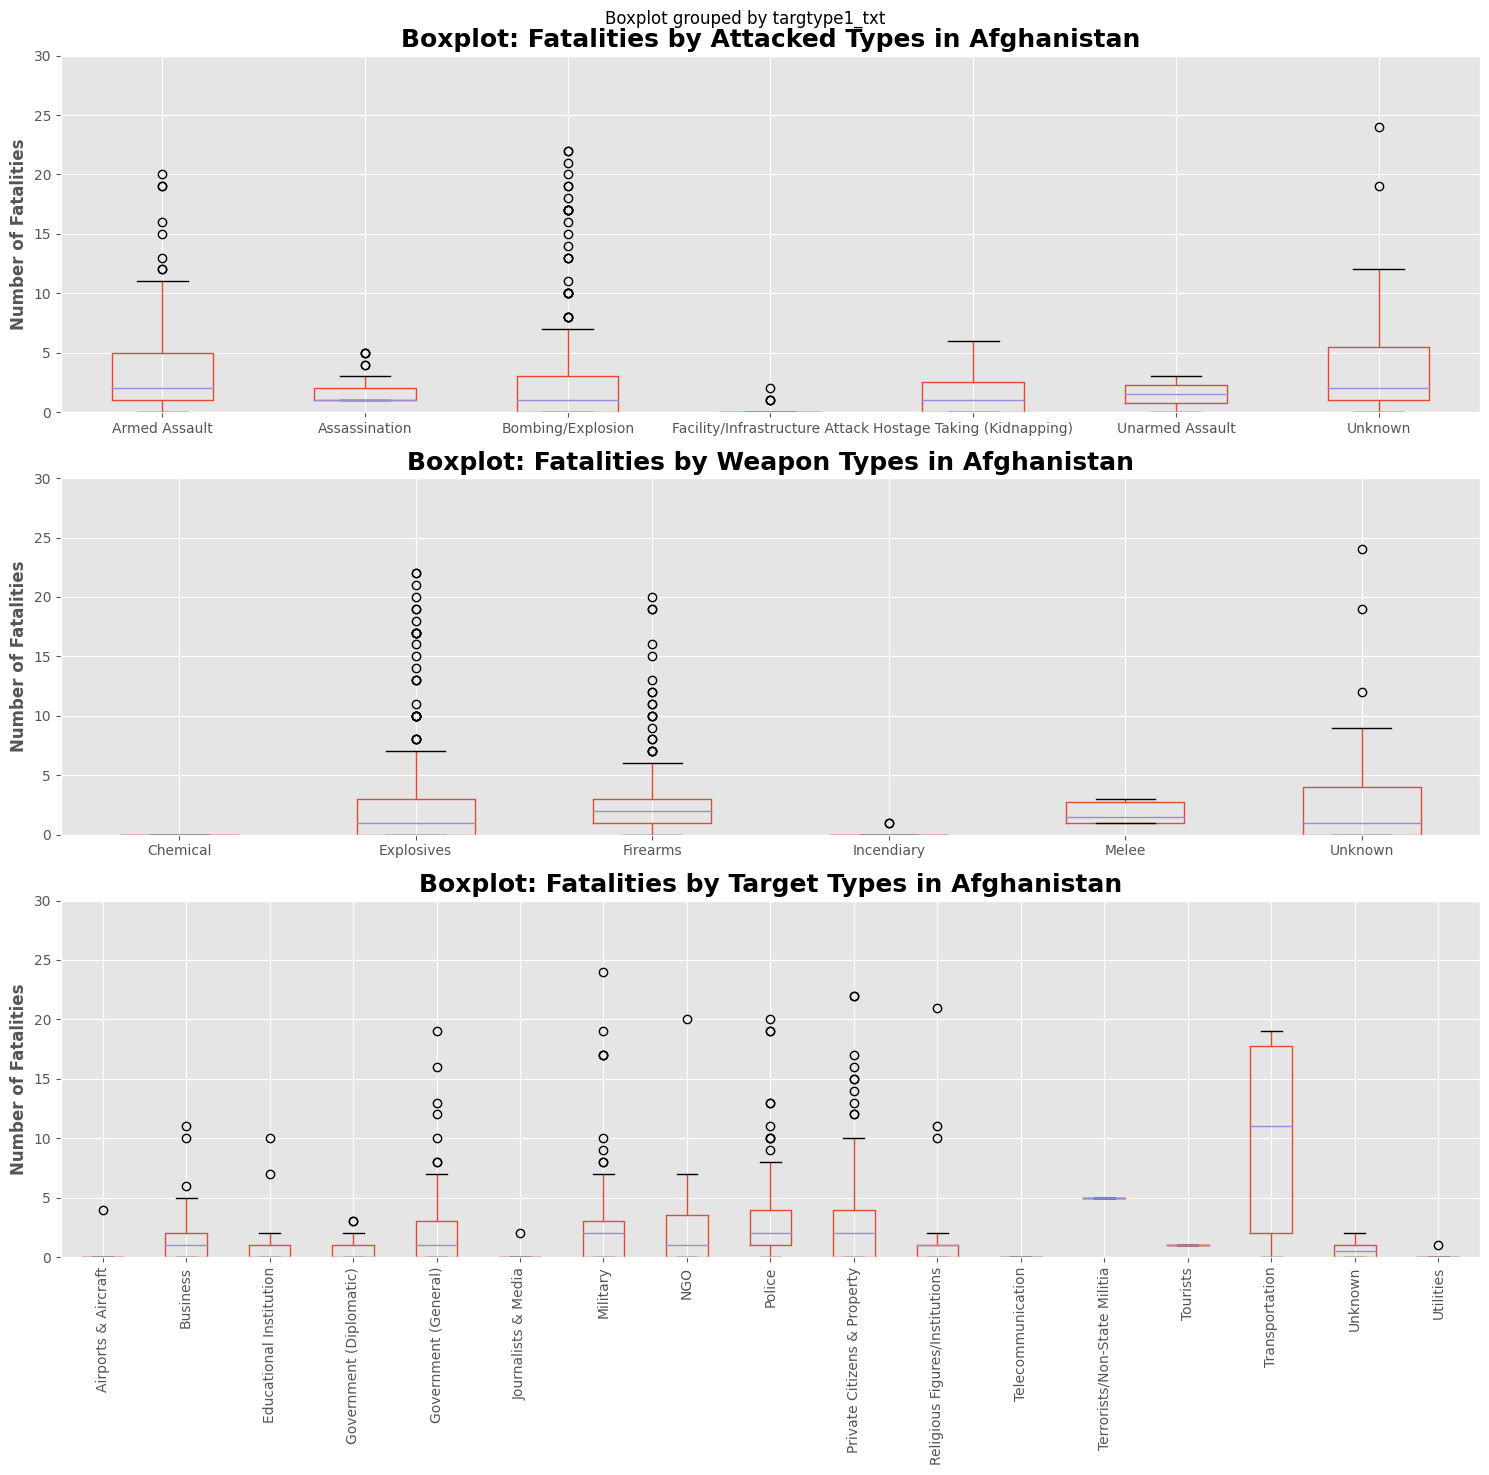

In [47]:
fig = plt.figure(figsize=(15,15)) 

# Attacked Types 
ax = fig.add_subplot(3,1,1)
salvo_df.query("success == 1 ").boxplot(by='attacktype1_txt' , column='nkill', ax=ax) 
ax.set_ylim([0,30 ])
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Boxplot: Fatalities by Attacked Types in Afghanistan", fontweight='bold', fontsize=18)
ax.set_xlabel("")

# Weapons used 
ax = fig.add_subplot(3,1,2)
salvo_df.query("success == 1 ").boxplot(by='weaptype1_txt' , column='nkill', ax=ax) 
ax.set_ylim([0,30 ])
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Boxplot: Fatalities by Weapon Types in Afghanistan", fontweight='bold', fontsize=18)
ax.set_xlabel("")

# Targets 
ax = fig.add_subplot(3,1,3)
salvo_df.query("success == 1 ").boxplot(by='targtype1_txt' , column='nkill', ax=ax) 
ax.set_ylim([0,30 ])
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Boxplot: Fatalities by Target Types in Afghanistan", fontweight='bold', fontsize=18)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout() 

## **Methods Used and Targets During the Incidents**

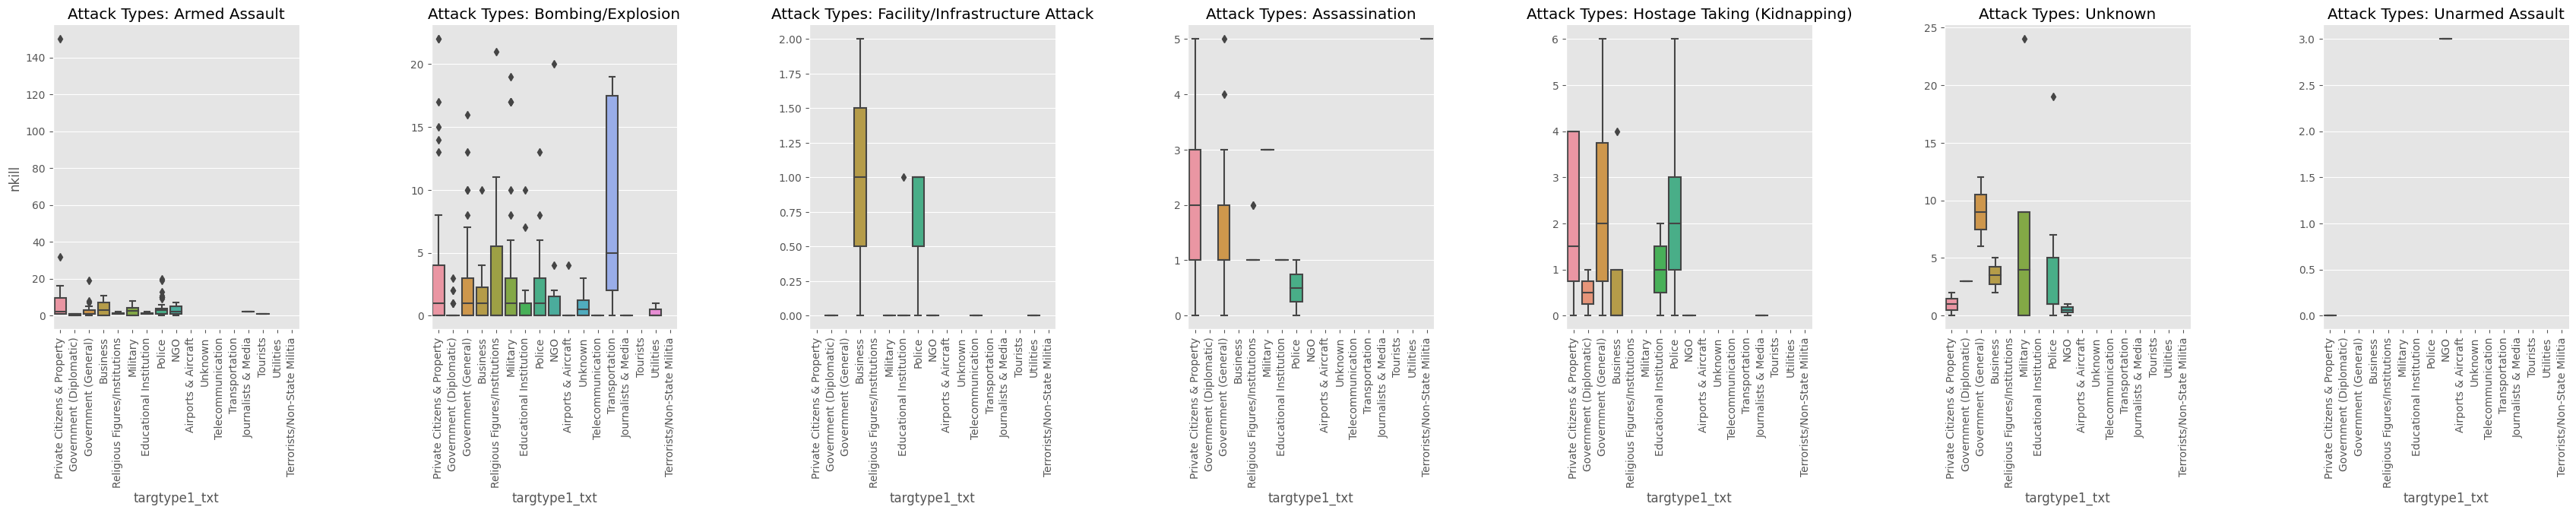

In [118]:
plt.rcParams['figure.figsize'] = (50,50)
ax = sns.catplot(data=salvo_df, col='attacktype1_txt',  x='targtype1_txt', y='nkill', kind='box', sharey=False)
for axis in ax.axes.ravel():
    axis.set_xticklabels(axis.get_xticklabels() , rotation=90)
    axis.set_title("Attack Types: %s" % (axis.title.get_text().split("=")[-1].strip() ) ) 

## **Attack Types Trends During (2001 - 2006)**
- Election: (October 9, 2004)
- Exploring the fatalities trends before, during, and after the Presidential Election (`Elected President Karzai`)

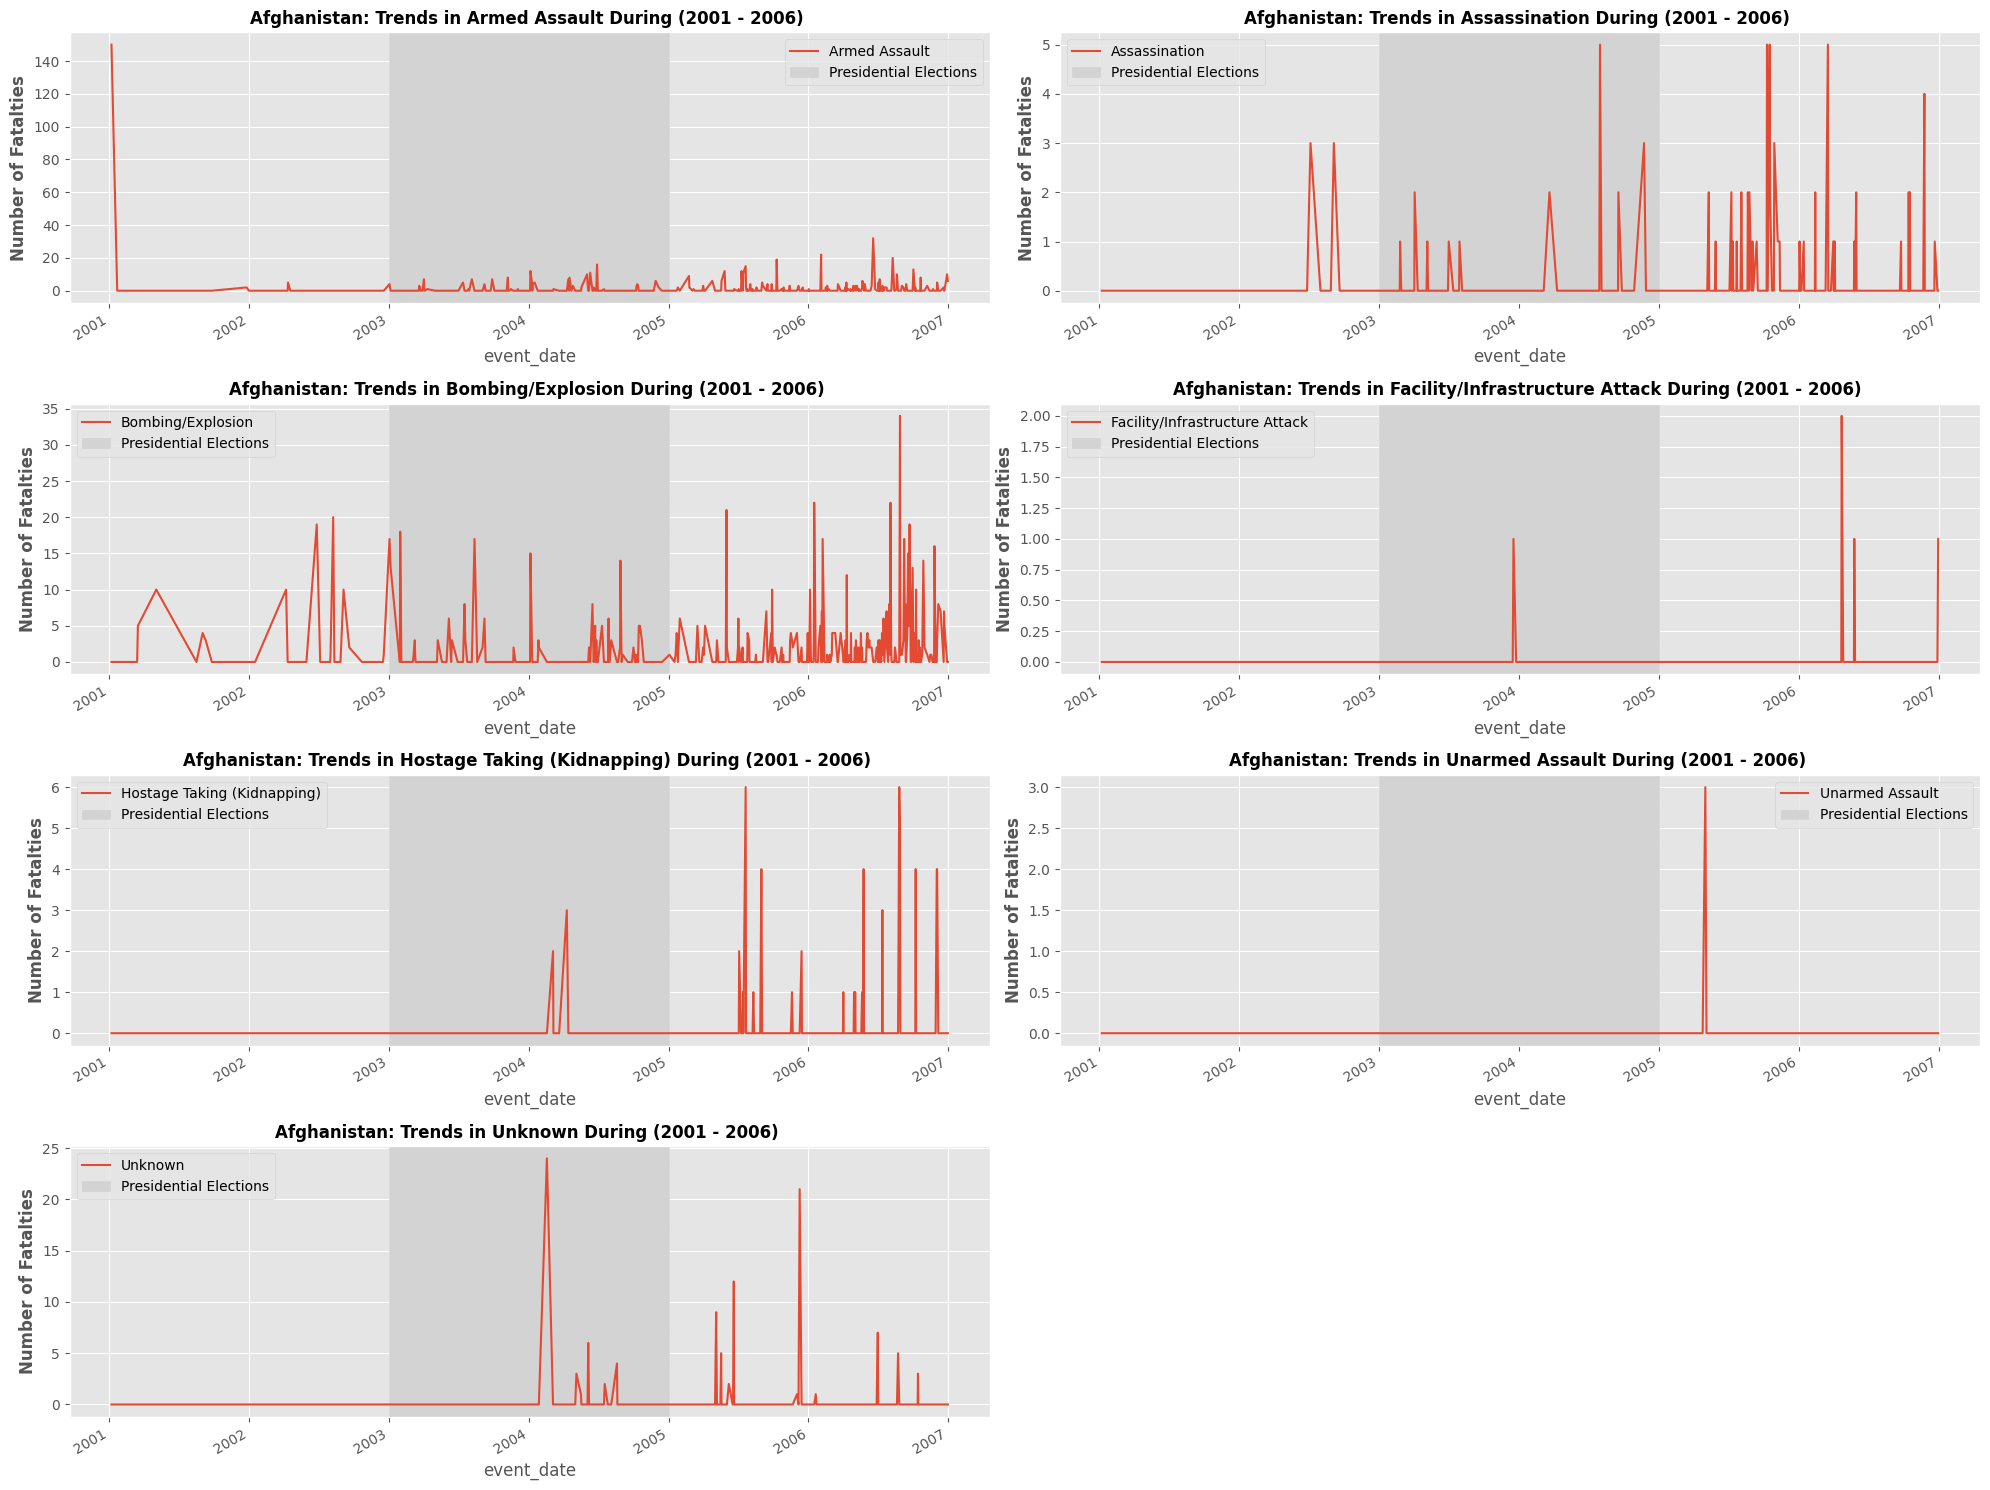

In [152]:
fig = plt.figure(figsize=(20,15))

events_tbl: 'DataFrame' = pd.pivot_table(data=salvo_df, index=['event_date'], columns=['attacktype1_txt'], values='nkill', aggfunc='sum').replace({np.nan:0.0})
for index,col in enumerate(events_tbl.columns.tolist(), 1):
    ax = fig.add_subplot(4,2,index) 
    events_tbl[col].plot(ax=ax) # .plot(ax=ax, marker='s', mec=2.3)
    ax.set_title("Afghanistan: Trends in %s During (2001 - 2006) " % (col), fontweight='bold', fontsize=12 )
    ax.set_ylabel("Number of Fatalties", fontweight='bold')
    ax.axvspan(xmin=pd.to_datetime("2003-01-01") , xmax=pd.to_datetime("2005-01-01"), edgecolor='k', color='lightgray', hatch="/", label="Presidential Elections" )
    ax.legend() 
    
plt.tight_layout() 

## **Public Holidays Afghanistan**

In [46]:
pd.io.html.read_html("https://en.wikipedia.org/wiki/Public_holidays_in_Afghanistan")[0][['Date', 'English Name']].set_index('Date')

,English Name
Date,
February 15,Liberation Day
March 21,Nowruz (New Day)
April 28,Mujahideen Victory Day
May 1,International Workers' Day
August 15,"""Afghan Jihad"" Victory Day[2]"
August 19,Afghan Independence Day
August 31,American Withdrawal Day[3]
September 9,Martyrs' Day
1 of Shawwal in the Islamic Calendar,Eid al-Fitr


## **Targeted Entities, Months, and Fatalities During (2001 - 2006) Incidents** 

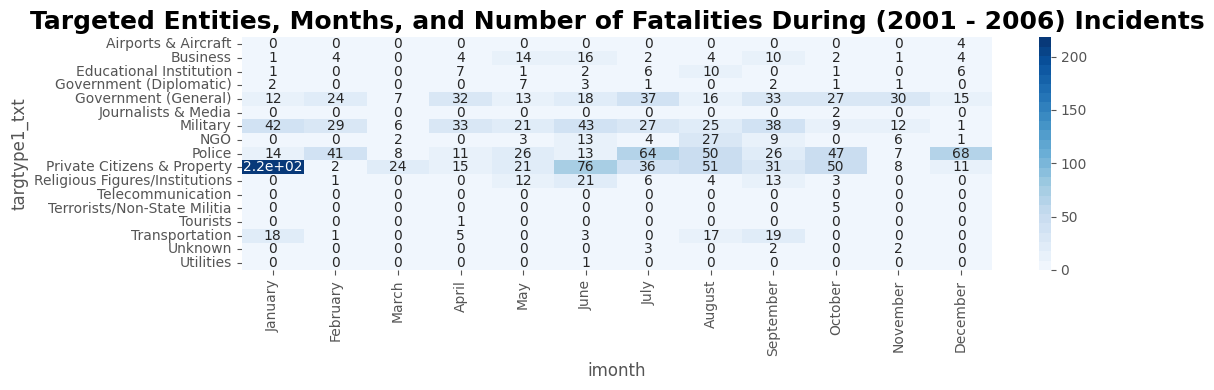

In [191]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot()
sns.heatmap(salvo_df.groupby(['targtype1_txt', 'imonth'])['nkill'].sum().unstack('imonth').replace({np.nan:0.0}).rename({ month:pd.to_datetime("2001-%s-01" % (month) ).month_name() for month in range(1,13) }, axis=1),
            cmap=ListedColormap(sns.color_palette(n_colors=25, palette='Blues')),
            annot=True)
ax.set_title("Targeted Entities, Months, and Number of Fatalities During (2001 - 2006) Incidents", fontweight='bold', fontsize=18)
plt.tight_layout() 

## **Perpetrators in Afghanistan**

In [201]:
pd.DataFrame(salvo_df['gname'].value_counts()).rename({'count': 'Number of Incidents'}, axis=1) 

,Number of Incidents
gname,
Taliban,396
Unknown,241
Al-Qaida,20
Hizb-I-Islami,6
Opposition Group,5
Haqqani Network,3
Anti-United States extremists,2
Jaish al-Muslimin (Army of the Muslims),2
Saif-ul-Muslimeen,1


## **Incidents involving the `Taliban`**

In [29]:
salvo_df.query("gname == 'Taliban' ").groupby(['imonth', 'iyear'])[['nkill', 'nwound']].sum().unstack('imonth').replace({np.nan:0.0}).rename(salvo_df[['imonth', 'Month']].drop_duplicates().sort_values(by='imonth').set_index('imonth').to_dict().get('Month'), axis=1)

nkill                                                          \
imonth January February March April   May  June  July August September   
iyear                                                                    
2001     150.0      0.0   0.0   0.0   0.0   0.0   0.0    0.0       3.0   
2002       0.0      0.0   0.0   5.0   0.0   0.0   0.0    0.0       0.0   
2003      13.0      1.0   3.0  10.0   3.0   1.0  15.0    7.0      20.0   
2004      26.0     24.0   3.0  21.0   3.0  56.0  14.0   10.0       2.0   
2005       7.0      9.0   6.0  16.0  17.0  17.0  74.0   20.0      33.0   
2006       9.0     64.0  22.0  34.0  36.0  43.0  37.0   69.0      67.0   

                                  nwound                                   \
imonth October November December January February March April   May  June   
iyear                                                                       
2001       0.0      0.0      0.0     0.0      0.0   0.0   0.0   0.0   0.0   
2002       0.0      0.0      0.0     0.0      0.0   0.0   0.0   4.0   0.0   
2003       0.0     11.0      2.0    50.0      3.0   6.0   0.0   6.0   8.0   
2004      22.0      9.0      2.0    50.0     10.0   0.0   9.0   0.0  15.0   
2005      37.0     20.0     37.0     5.0      0.0  33.0   0.0  11.0   4.0   
2006      28.0     24.0     41.0     3.0     52.0  10.0  62.0  33.0  14.0   

                                                         
imonth  July August September October November December  
iyear                                                    
2001     0.0    0.0       1.0     0.0      0.0      0.0  
2002     0.0    0.0       0.0     0.0      0.0      0.0  
2003     5.0    0.0      21.0     0.0      3.0     29.0  
2004    12.0    7.0       1.0    21.0      0.0      4.0  
2005    38.0   10.0      33.0    14.0     26.0     26.0  
2006    77.0   73.0      90.0    28.0     27.0     13.0

## **Deadliest Year in Afghanistan: 2006** 
- Types of attacks and targets by season

In [56]:
salvo_df.query("gname == 'Taliban' ").set_index('event_date')["2006":].groupby(['targtype1_txt','weaptype1_txt','season'])['nkill'].sum().unstack("weaptype1_txt").replace({np.nan:0.0}).astype(int)
# Escalation in 2006

weaptype1_txt                          Explosives  Firearms  Incendiary  \
targtype1_txt                  season                                     
Airports & Aircraft            Winter           4         0           0   
Business                       Spring           0         3           0   
                               Winter           4         0           0   
Educational Institution        Autumn           0         0           0   
                               Spring           7         1           0   
                               Summer           1         0           0   
                               Winter           0         0           0   
Government (Diplomatic)        Spring           2         1           0   
Government (General)           Autumn          40         2           0   
                               Spring           5        13           0   
                               Summer          15         0           0   
                               Winter           8        22           0   
Journalists & Media            Autumn           0         0           0   
Military                       Autumn          18         0           0   
                               Spring          13         0           0   
                               Summer          30         6           0   
                               Winter           8         0           0   
NGO                            Autumn           4         0           0   
                               Summer           0         2           0   
Police                         Autumn           0        23           0   
                               Spring           5        23           0   
                               Summer           5        37           0   
                               Winter          44        16           1   
Private Citizens & Property    Autumn           0         6           0   
                               Spring           4         8           0   
                               Summer           3        37           0   
                               Winter           0         0           0   
Religious Figures/Institutions Winter           1         0           0   
Transportation                 Autumn          19         0           0   
Unknown                        Summer           3         0           0   

weaptype1_txt                          Melee  Unknown  
targtype1_txt                  season                  
Airports & Aircraft            Winter      0        0  
Business                       Spring      1        0  
                               Winter      0        0  
Educational Institution        Autumn      0        0  
                               Spring      0        0  
                               Summer      0        0  
                               Winter      1        0  
Government (Diplomatic)        Spring      0        0  
Government (General)           Autumn      0        0  
                               Spring      0        1  
                               Summer      0        0  
                               Winter      2        0  
Journalists & Media            Autumn      0        0  
Military                       Autumn      0        0  
                               Spring      0        0  
                               Summer      0        0  
                               Winter      0        0  
NGO                            Autumn      0        0  
                               Summer      0        0  
Police                         Autumn      0        3  
                               Spring      4        1  
                               Summer      0       10  
                               Winter      0        1  
Private Citizens & Property    Autumn      0        4  
                               Spring      0        0  
                               Summer      0        0  
                               

## **Number of Successful v.s. Unsuccessful Attack Frequency in Afghanistan** 
- By Season 

In [137]:
salvo_df.groupby(['season', 'success']).size().unstack('season').rename({0:'Unsuccessful Attacked', 1:'Successful Attacked'}, axis=0)

season,Autumn,Spring,Summer,Winter
success,,,,
Unsuccessful Attacked,12,11,12,5
Successful Attacked,145,168,191,134


- **By Province** 

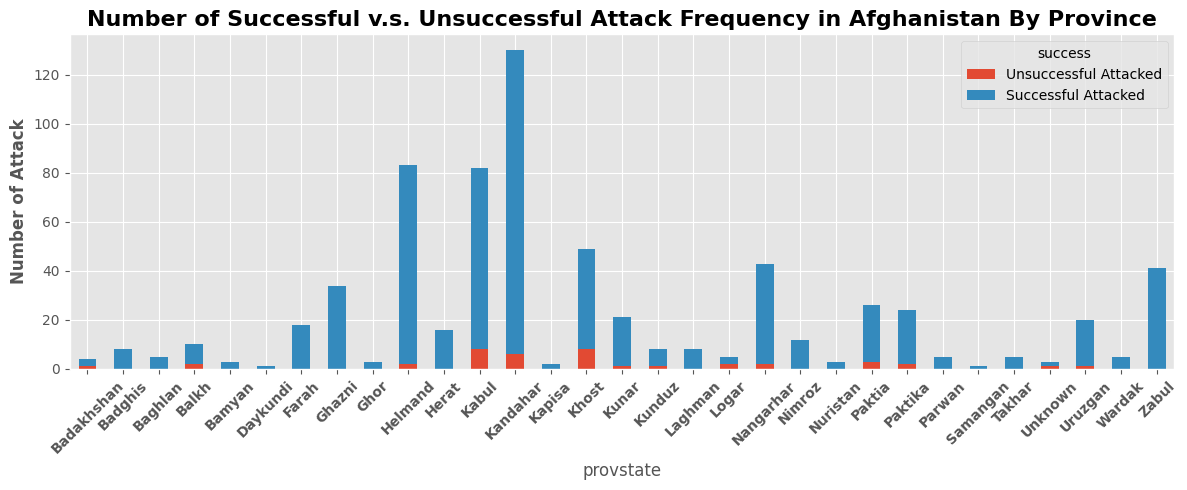

In [142]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot() 

salvo_df.groupby(['provstate', 'success']).size().unstack('success').replace({np.nan:0.0}).astype(int).rename({0:'Unsuccessful Attacked', 1:'Successful Attacked'}, axis=1).plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Number of Successful v.s. Unsuccessful Attack Frequency in Afghanistan By Province", fontweight='bold', fontsize=16) 
ax.set_ylabel("Number of Attack", fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', rotation=45)
plt.tight_layout() 

## **Afghan Infrastructures and Provinces targeted by the Talibans**

In [222]:
salvo_df.query("gname == 'Taliban' ").groupby(['provstate', 'targtype1_txt'])['nkill'].agg('mean').unstack('targtype1_txt').replace({np.nan:0.0})

targtype1_txt,Airports & Aircraft,Business,Educational Institution,Government (Diplomatic),Government (General),Journalists & Media,Military,NGO,Police,Private Citizens & Property,Religious Figures/Institutions,Telecommunication,Terrorists/Non-State Militia,Tourists,Transportation,Unknown,Utilities
provstate,,,,,,,,,,,,,,,,,
Badakhshan,0.0,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Badghis,0.0,0.000000,0.000000,0.000000,5.000000,0.0,7.000000,3.333333,0.000000,5.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Baghlan,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Balkh,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Bamyan,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,150.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Daykundi,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,15.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Farah,0.0,1.666667,0.000000,0.000000,1.250000,0.0,1.000000,0.000000,2.500000,4.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Ghazni,0.0,2.000000,0.000000,1.000000,3.200000,0.0,10.000000,2.500000,1.600000,2.400000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Helmand,0.0,2.500000,0.600000,0.000000,4.166667,0.0,7.666667,2.666667,4.826087,2.200000,0.75,0.0,0.0,0.0,0.0,3.0,0.0


## **Targeted Groups/Individuals during 2001 - 2006 Afghanistan Conflict**

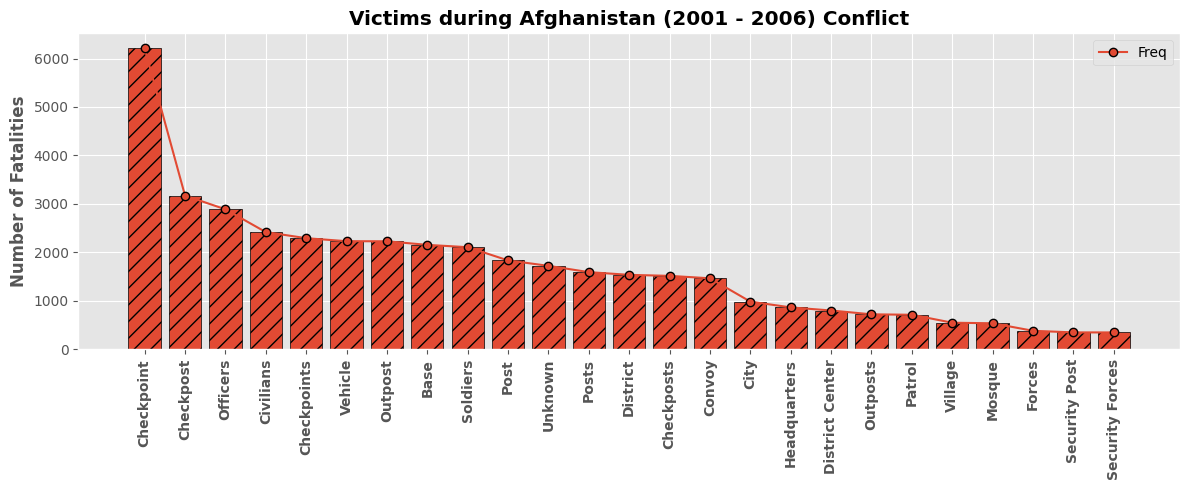

In [231]:
targets, freqs = zip(*afghan_df.groupby('target1')['nkill'].sum().sort_values(ascending=False).head(25).to_dict().items() ) 

fig = plt.figure(figsize=(12,5)) 
ax = fig.add_subplot() 
ax.bar(x=list(targets), height=list(freqs), edgecolor='k', hatch="//")
pd.DataFrame(list(freqs), index=list(targets)).rename({0: 'Freq'}, axis=1).plot( marker='o', ax=ax, mec='black' )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold')
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Victims during Afghanistan (2001 - 2006) Conflict", fontweight='bold')
plt.tight_layout() 

## **Afghanistan Suicide Attacked** 

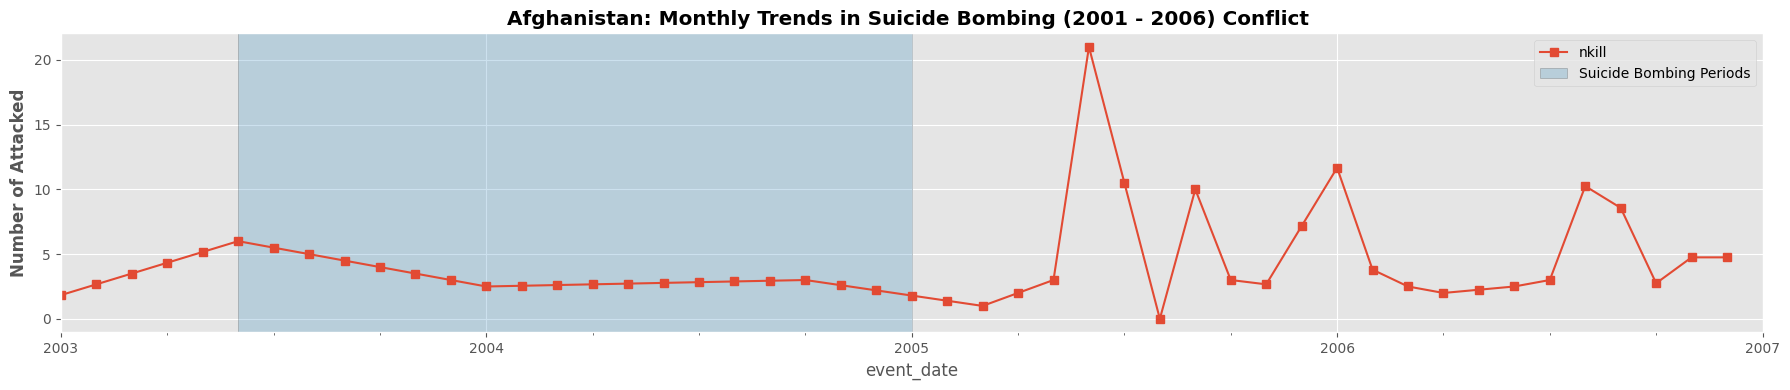

In [374]:
fig = plt.figure(figsize=(18,4)) 
ax = fig.add_subplot() 
afghan_df.query("suicide == 1 and iyear >= 2001 and iyear <= 2006 ").groupby('event_date')['nkill'].sum().resample('M').mean().interpolate().plot(marker='s') 
ax.set_xlim([pd.to_datetime("2003-01-01"), pd.to_datetime("2007-01-31" )] )
ax.set_title("Afghanistan: Monthly Trends in Suicide Bombing (2001 - 2006) Conflict ", fontweight='bold')
# President Karzai elected at 2004 (Trends in suicide bombing during that period) 
ax.axvspan(xmin=pd.to_datetime("2003-06-01"), xmax=pd.to_datetime("2005-01-01") , edgecolor='k', alpha=0.25, label="Suicide Bombing Periods" ) 
ax.set_ylabel("Number of Attacked", fontweight='bold')
ax.legend()
plt.tight_layout() 

## **Targets/Victims in AFG major cities**

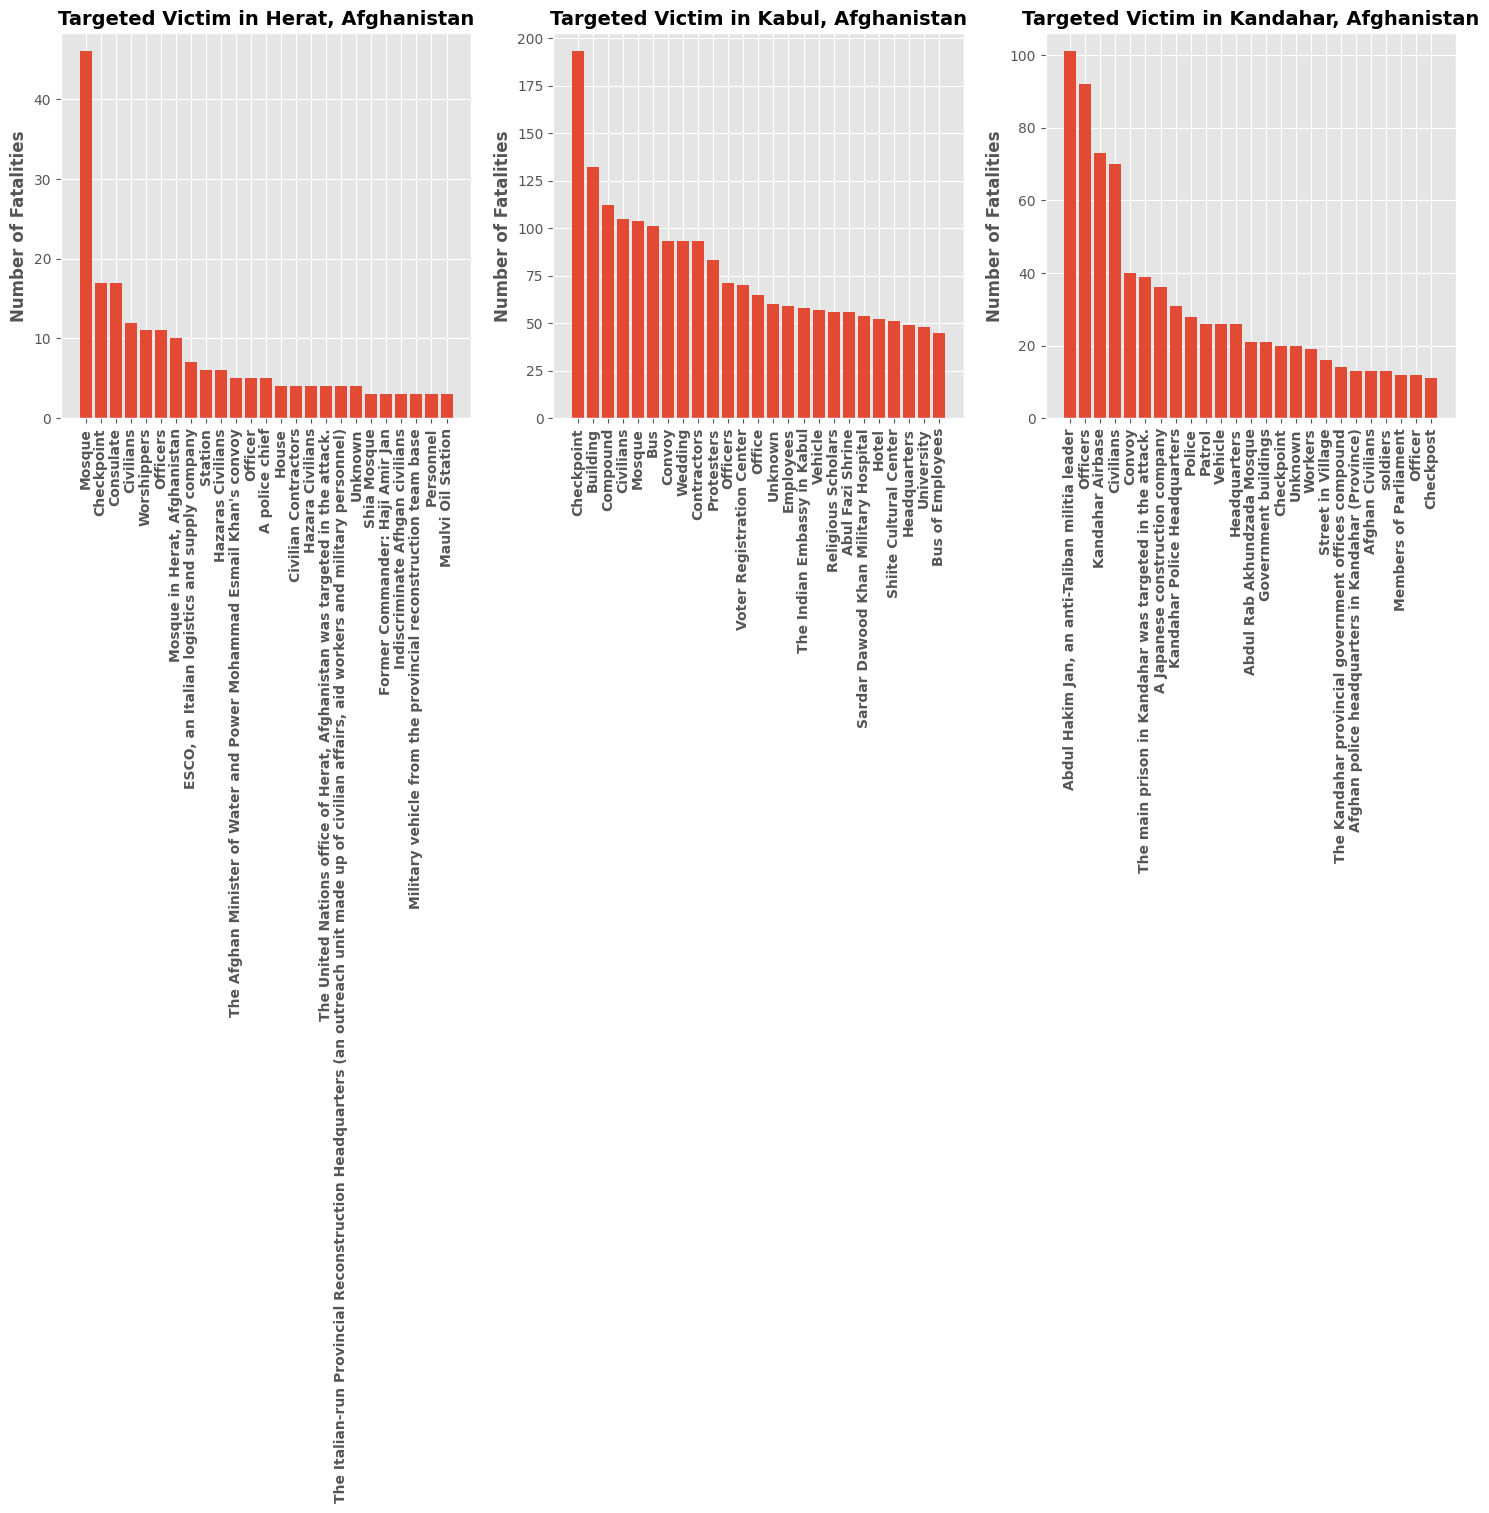

In [224]:
major_cities: List[str] = ['Herat', 'Kabul', 'Kandahar']
fatalities_mc: 'DataFrame' = afghan_df[ afghan_df['city'].isin(major_cities)].groupby(['city', 'target1'])['nkill'].sum().unstack('city').replace({np.nan:0.0})

# target in major cities in AFG (2001 - 2006 )
fig = plt.figure(figsize=(18,5))
for index,city in enumerate(major_cities, 1): 
    ax = fig.add_subplot(1,3,index)
    targets ,freqs = zip(*fatalities_mc[city].sort_values(ascending=False).head(25).to_dict().items())
    ax.bar(x=list(targets), height=list(freqs))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold')
    ax.set_title("Targeted Victim in %s, Afghanistan" % (city.title()), fontweight='bold', fontsize=14 )
    ax.set_ylabel("Number of Fatalities", fontweight='bold')
plt.tight_layout()

## **Target/Victims during Afghanistan Conflict (2001 - 2006) by Month**

In [193]:
afghan_df['month_name'] = afghan_df['event_date'].apply(lambda row: row.month_name())
afghan_df.groupby(['imonth', 'target1'])['nkill'].sum().sort_values(ascending=False).unstack('imonth').head(25).replace({np.nan:0.0}).rename(dict(zip(range(1,13), afghan_df[['imonth', 'month_name' ]].sort_values(by='imonth')['month_name'].unique().tolist() )), axis=1)

imonth,January,February,March,April,May,June,July,August,September,October,November,December
target1,,,,,,,,,,,,
(District) Chief Arbab Mohammad and local judge Mawlawi Mohammad Nasim,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(District) Chief Mohammad Mobin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
(District) Head of Shah Wali Kot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
(District) judge of Kandahar (Province),0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
(District) security command,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111 Kabul Division Military Vehicle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
11th Police District,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 year old boy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1st Regiment Checkpost,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0


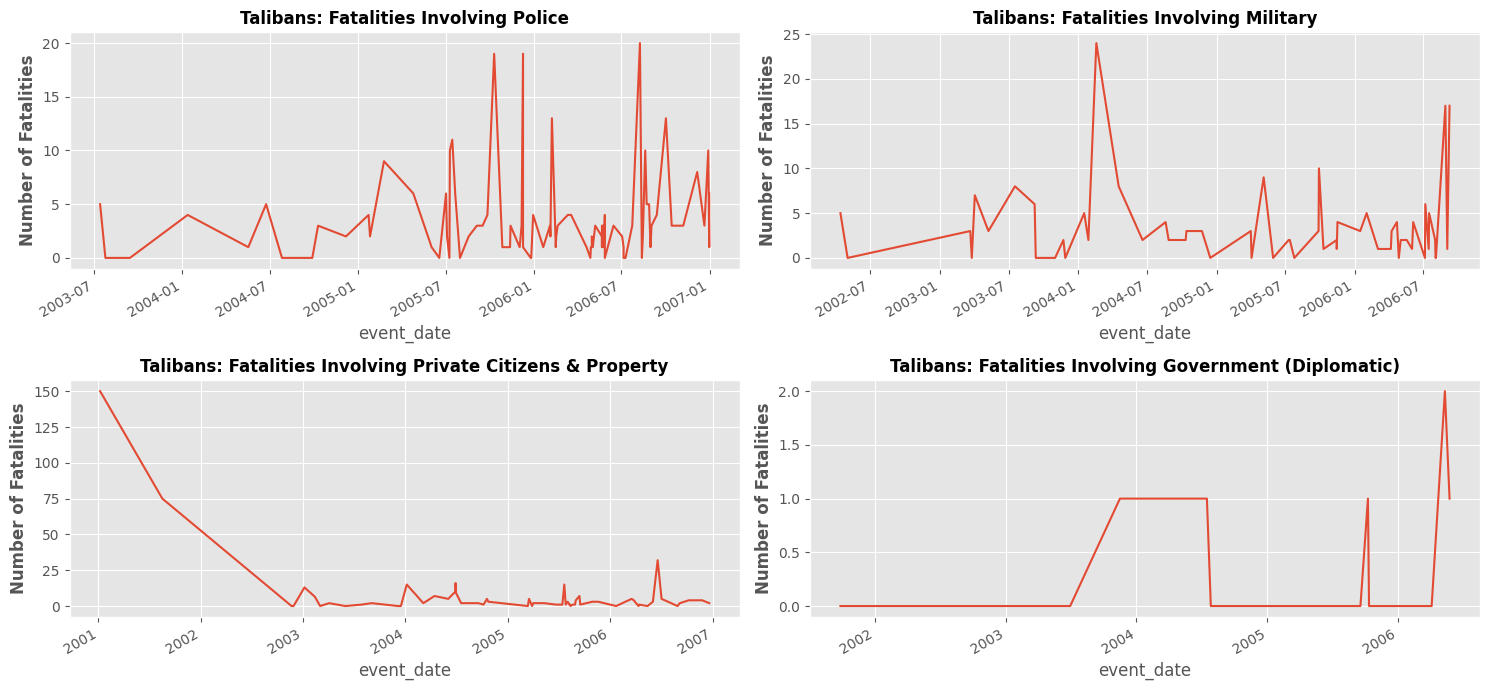

In [70]:
fig = plt.figure(figsize=(15,7)) 
for index, target in enumerate(['Police', 'Military', 'Private Citizens & Property', 'Government (Diplomatic)'], 1):
    ax = fig.add_subplot(2,2,index)
    salvo_df.query(f"gname == 'Taliban' and targtype1_txt == '{target}' ").set_index('event_date')['nkill'].interpolate().plot(ax=ax)
    ax.set_title(f"Talibans: Fatalities Involving %s" % (target) , fontweight='bold', fontsize=12)
    ax.set_ylabel("Number of Fatalities", fontweight='bold')
    
plt.tight_layout()

# **Modeling Fatalities** 
## **Events in Kandahar During Afghanistan War (2001 - 2006)** 

In [36]:
kandahar_df: 'DataFrame' = salvo_df.query("provstate == 'Kandahar' ")
pd.pivot_table(data=salvo_df.query("provstate == 'Kandahar'" ), index=['iyear','targtype1_txt' ], columns=['attacktype1_txt', 'weaptype1_txt'], values='nkill', aggfunc='sum').replace({np.nan:0.0})

attacktype1_txt                      Armed Assault Assassination           \
weaptype1_txt                             Firearms    Explosives Firearms   
iyear targtype1_txt                                                         
2002  Government (General)                     0.0           0.0      3.0   
      Military                                 0.0           0.0      0.0   
      Private Citizens & Property              0.0           0.0      0.0   
      Unknown                                  0.0           0.0      0.0   
2003  Educational Institution                  0.0           0.0      0.0   
      Government (Diplomatic)                  0.0           0.0      0.0   
      Government (General)                     0.0           0.0      0.0   
      Military                                 3.0           0.0      0.0   
      NGO                                      0.0           0.0      0.0   
      Police                                   5.0           0.0      0.0   
      Private Citizens & Property              1.0           0.0      0.0   
      Religious Figures/Institutions           0.0           0.0      2.0   
      Transportation                           0.0           0.0      0.0   
      Unknown                                  0.0           0.0      0.0   
2004  Government (Diplomatic)                  0.0           0.0      0.0   
      Government (General)                     3.0           0.0      0.0   
      Military                                10.0           0.0      0.0   
      NGO                                      0.0           0.0      0.0   
      Police                                   1.0           0.0      0.0   
      Private Citizens & Property              0.0           0.0      2.0   
2005  Business                                 0.0           0.0      0.0   
      Educational Institution                  0.0           0.0      1.0   
      Government (Diplomatic)                  0.0           0.0      0.0   
      Government (General)                     0.0           0.0      2.0   
      Military                                 6.0           0.0      0.0   
      Police                                  19.0           0.0      0.0   
      Private Citizens & Property              1.0           0.0      0.0   
      Religious Figures/Institutions           1.0           0.0      3.0   
      Terrorists/Non-State Militia             0.0           5.0      0.0   
2006  Business                                 0.0           0.0      0.0   
      Educational Institution                  0.0           0.0      0.0   
      Government (Diplomatic)                  0.0           0.0      0.0   
      Government (General)                     1.0           0.0      4.0   
      Military                                 0.0           0.0      0.0   
      NGO                                      2.0           0.0      0.0   
      Police                                  24.0           0.0      0.0   
      Private Citizens & Property             33.0           0.0      0.0   
      Religious Figures/Institutions           1.0           0.0      0.0   
      Transportation                           0.0           0.0      0.0   

attacktype1_txt                      Bombing/Explosion           \
weaptype1_txt                               Explosives Firearms   
iyear targtype1_txt                                               
2002  Government (General)                         0.0      0.0   
      Military                                    19.0      0.0   
      Private Citizens & Property                  0.0      0.0   
      Unknown                                      2.0      0.0   
2003  Educational Institution                      0.0      0.0   
      Government (Diplomatic)                      0.0      0.0   
      Government (General)                         0.0      0.0   
      Military                                     6.0      0.0   
      NGO                   

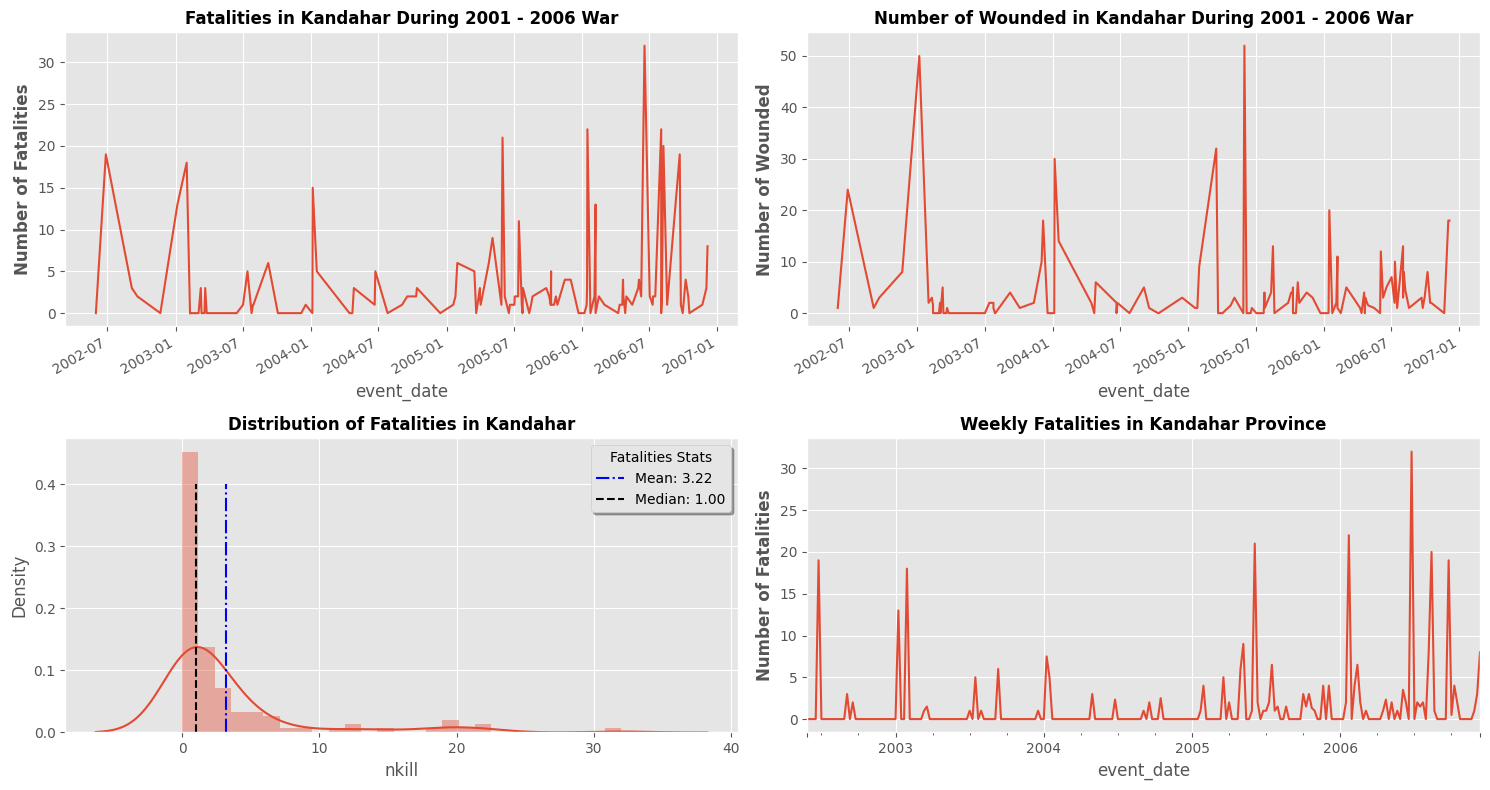

In [163]:
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(2,2,1) 
kandahar_df.set_index('event_date')['nkill'].plot(ax=ax) 
ax.set_title("Fatalities in Kandahar During 2001 - 2006 War", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

ax = fig.add_subplot(2,2,2) 
kandahar_df.set_index('event_date')['nwound'].interpolate().plot(ax=ax) 
ax.set_title("Number of Wounded in Kandahar During 2001 - 2006 War", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Wounded", fontweight='bold')

ax = fig.add_subplot(2,2,3)
sns.distplot( kandahar_df['nkill'], ax=ax)
mean: float = kandahar_df['nkill'].mean() 
median: float = kandahar_df['nkill'].median() 
ax.vlines(x=mean, ymin=0, ymax=0.4, linestyle="-.", color='blue', label=f"Mean: {mean:.2f}")
ax.vlines(x=median, ymin=0, ymax=0.4, linestyle="--", color='black', label=f"Median: {median:.2f}")
ax.legend(title="Fatalities Stats", shadow=True, fancybox=True )
ax.set_title("Distribution of Fatalities in Kandahar", fontweight='bold', fontsize=12)

ax = fig.add_subplot(2,2,4)
kandahar_df.set_index('event_date')['nkill'].resample("W").mean().replace({np.nan:0.0}).plot(ax=ax)
ax.set_title("Weekly Fatalities in Kandahar Province", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

plt.tight_layout()

## **Kandahar Group Responsible, Targeted Infrastructures, and Attacked Types**

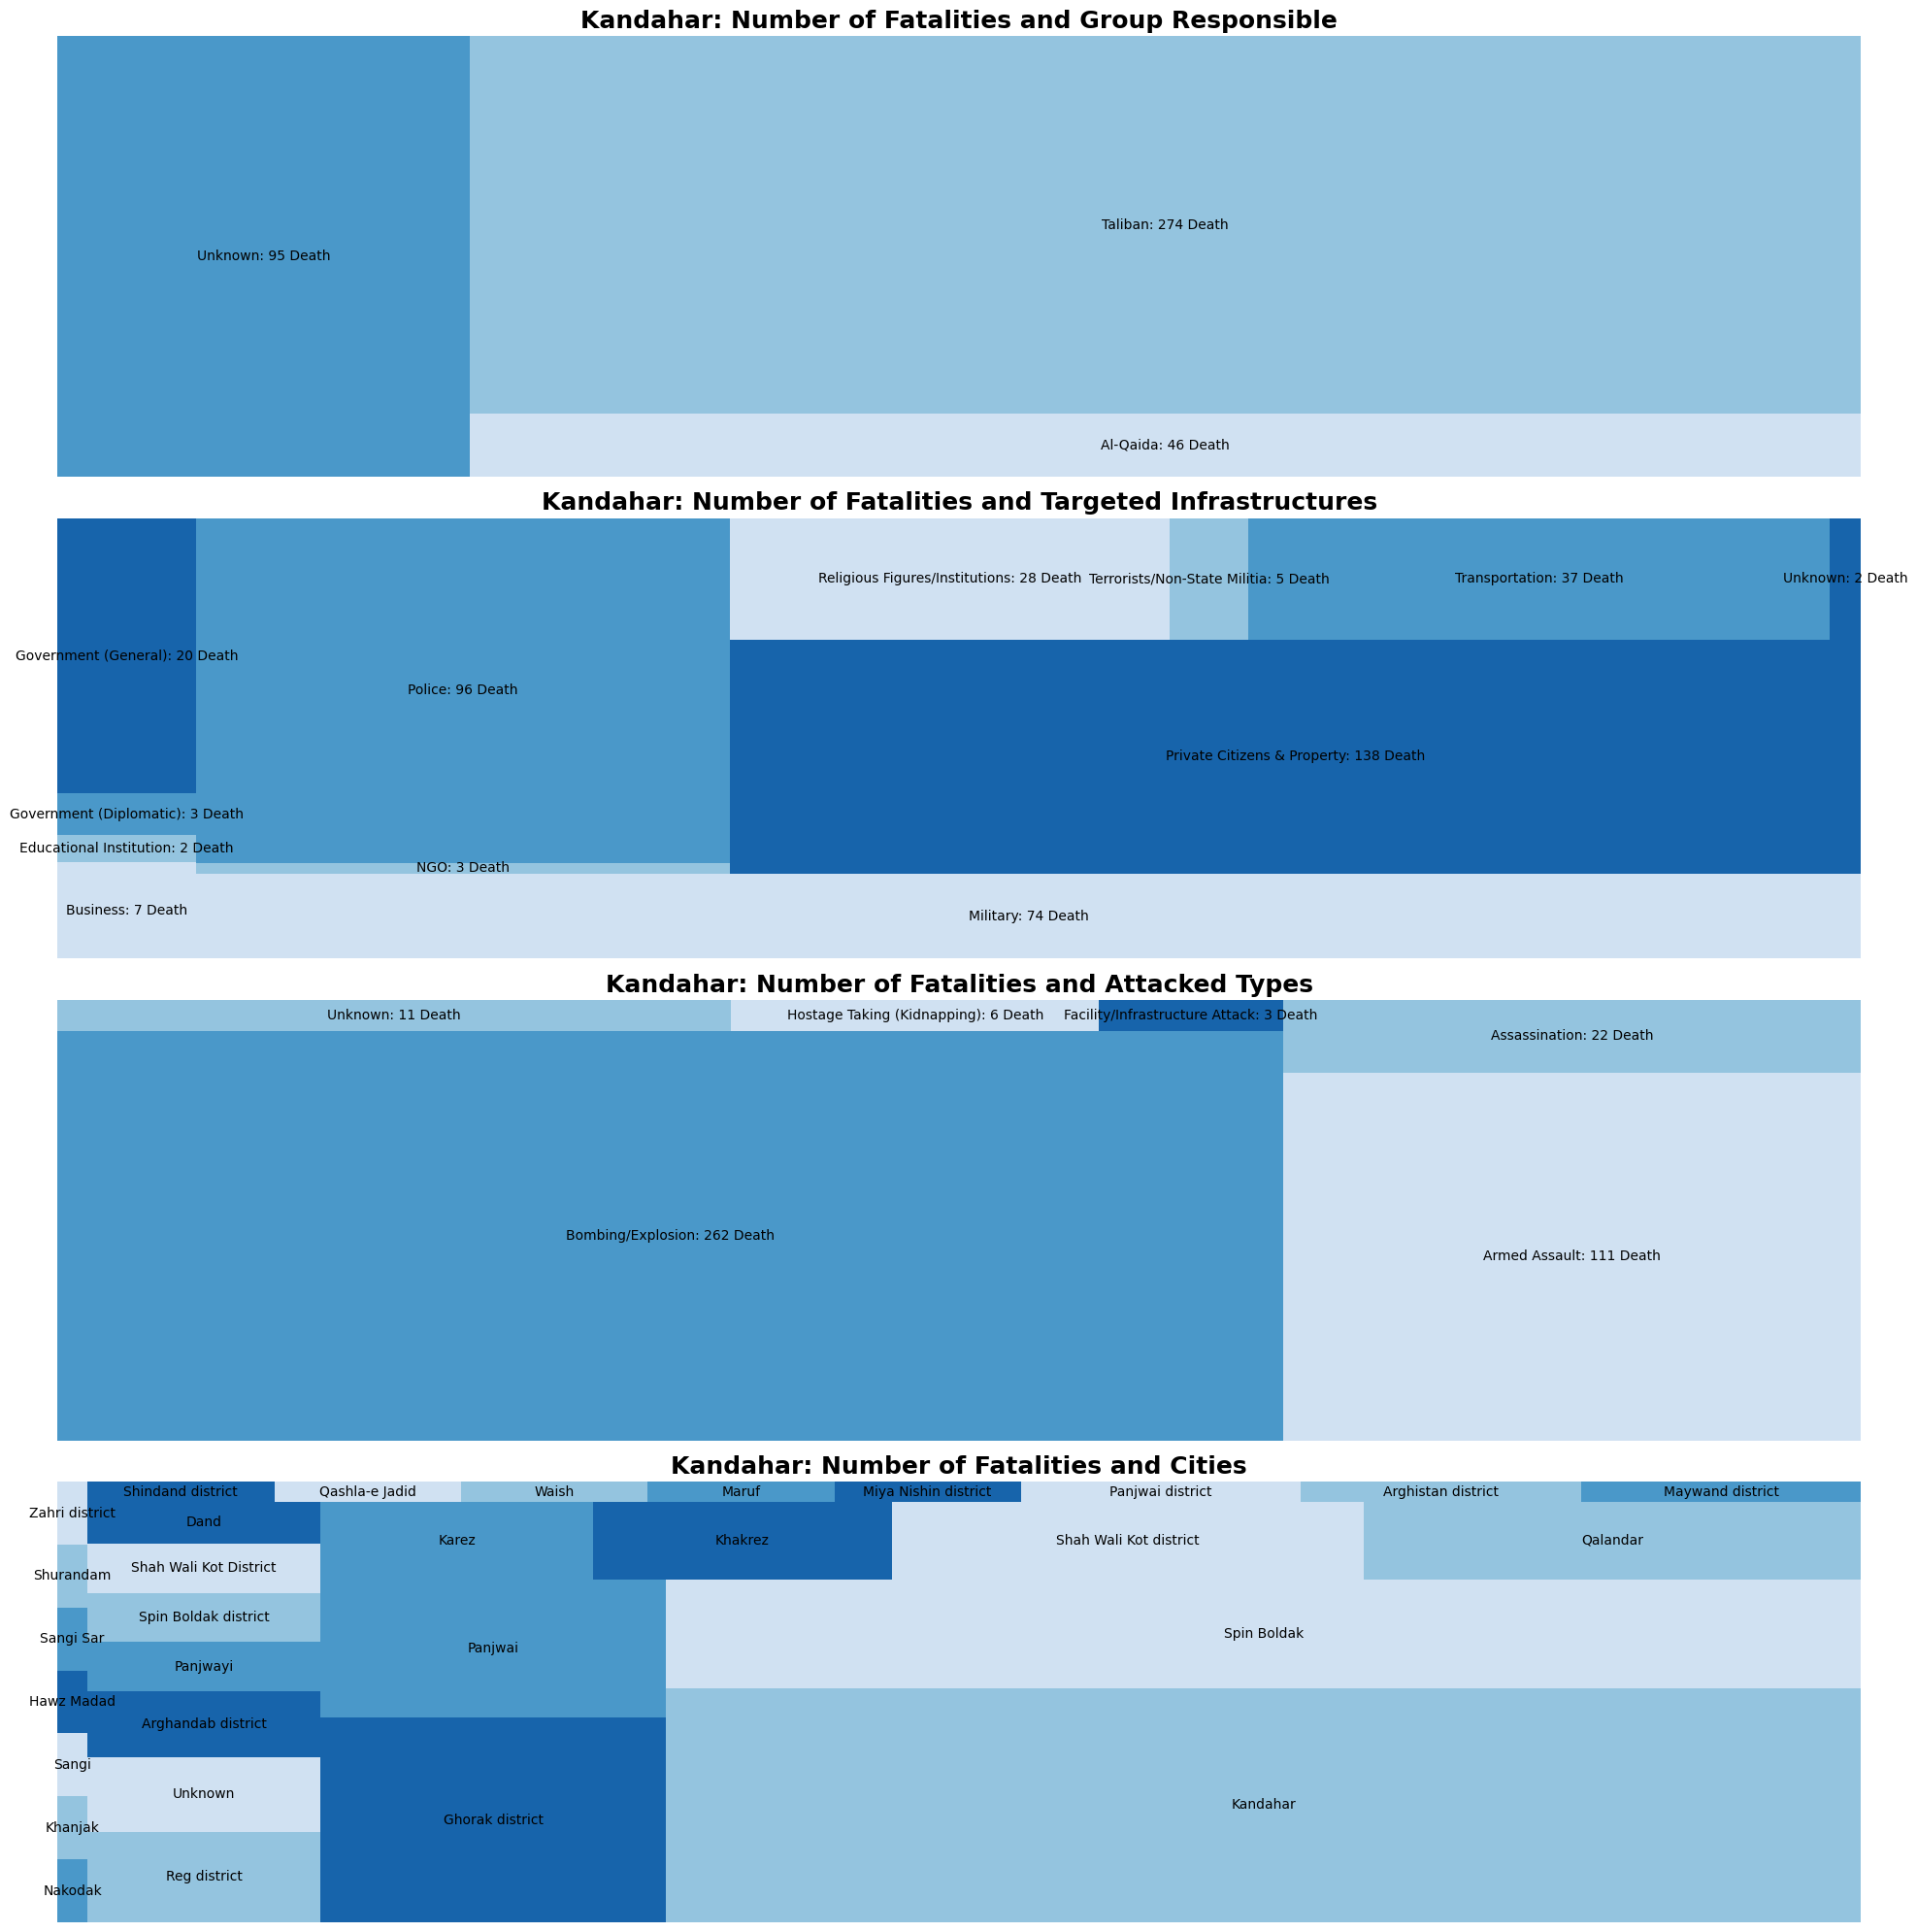

In [147]:
fig = plt.figure(figsize=(20,20)) 

ax = fig.add_subplot(4,1,1) 
groups,fatalities = zip(*kandahar_df.groupby('gname')['nkill'].sum().to_dict().items())
sq.plot(sizes=list(fatalities), 
        label=[ "%s: %s Death" % (item[0], int(item[1]) ) for item in zip(groups, fatalities) ], 
        color=sns.color_palette(palette='Blues', n_colors=4).as_hex(),
        ax=ax)
ax.axis('off')
ax.set_title("Kandahar: Number of Fatalities and Group Responsible", fontweight='bold', fontsize=18) 
ax.invert_xaxis() 

ax = fig.add_subplot(4,1,2) 
infrastructures, fatalities = zip(*kandahar_df.groupby('targtype1_txt')['nkill'].sum().to_dict().items())
sq.plot(sizes=list(fatalities), 
        label=[ "%s: %s Death" % (item[0], int(item[1]) ) for item in zip(infrastructures, fatalities) ], 
        color=sns.color_palette(palette='Blues', n_colors=4).as_hex(),
        ax=ax)
ax.axis('off')
ax.set_title("Kandahar: Number of Fatalities and Targeted Infrastructures", fontweight='bold', fontsize=18) 
# ax.invert_yaxis() 

ax = fig.add_subplot(4,1,3) 
attacked_types, fatalities = zip(*kandahar_df.groupby('attacktype1_txt')['nkill'].sum().to_dict().items())
sq.plot(sizes=list(fatalities), 
        label=[ "%s: %s Death" % (item[0], int(item[1]) ) for item in zip(attacked_types, fatalities) ], 
        color=sns.color_palette(palette='Blues', n_colors=4).as_hex(),
        ax=ax)
ax.axis('off')
ax.set_title("Kandahar: Number of Fatalities and Attacked Types", fontweight='bold', fontsize=18) 
ax.invert_xaxis() 

ax = fig.add_subplot(4,1,4) 
kandahar_stats: 'Series' = kandahar_df.groupby('city')['nkill'].sum()
kandahar_stats = kandahar_stats.replace({0.0: np.nan}).dropna().sort_values()
cities, fatalities = zip(*kandahar_stats.to_dict().items())

sq.plot(sizes=list(fatalities), 
        label=cities, 
        color=sns.color_palette(palette='Blues', n_colors=4).as_hex(),
        ax=ax)
ax.axis('off')
ax.set_title("Kandahar: Number of Fatalities and Cities", fontweight='bold', fontsize=18) 
ax.invert_yaxis() 

plt.tight_layout() 

## **Events in Kabul** 

In [18]:
kabul_df:  'DataFrame' = salvo_df.query("provstate == 'Kabul' ") 
kabul_df = kabul_df.drop(kabul_df.columns.tolist()[0], axis=1)
kabul_df.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,...,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date,Month,DayName,gname_mapped,season
1,200101220006,2001,1,22,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1,0,Near a United Nations building and the unoccup...,1/22/2001: A bomb exploded near the unoccupied...,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,...,4.0,Unknown,NaN,"A cement wall was damaged, as was a tree",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Bomb explodes near Iranian Embassy, UN buildi...","""Blasts shake Afghan capital,"" Agence France-P...","""Fifth explosion in week hits Afghan capital,""...",UMD Schmid 2012,-9,-9,1,1,NaN,2001-01-22,January,Monday,1,Winter
2,200102010001,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1,0,Near the ministry of education in downtown Kabul,2/1/2001: A bomb exploded near the Ministry of...,1,1,1,0,NaN,NaN,1,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,2,...,4.0,Unknown,NaN,Windows in near-by stores were broken in the e...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01,February,Thursday,1,Winter
3,200102010005,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1,0,In front of the tribal affairs ministry in dow...,2/1/2001: A bomb hidden in a sewer drain explo...,1,1,1,0,NaN,NaN,1,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,2,...,4.0,Unknown,NaN,A brick wall in front of the ministry was dama...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01,February,Thursday,1,Winter


## **Fatalities Trends in Kabul (2001 - 2006)** 

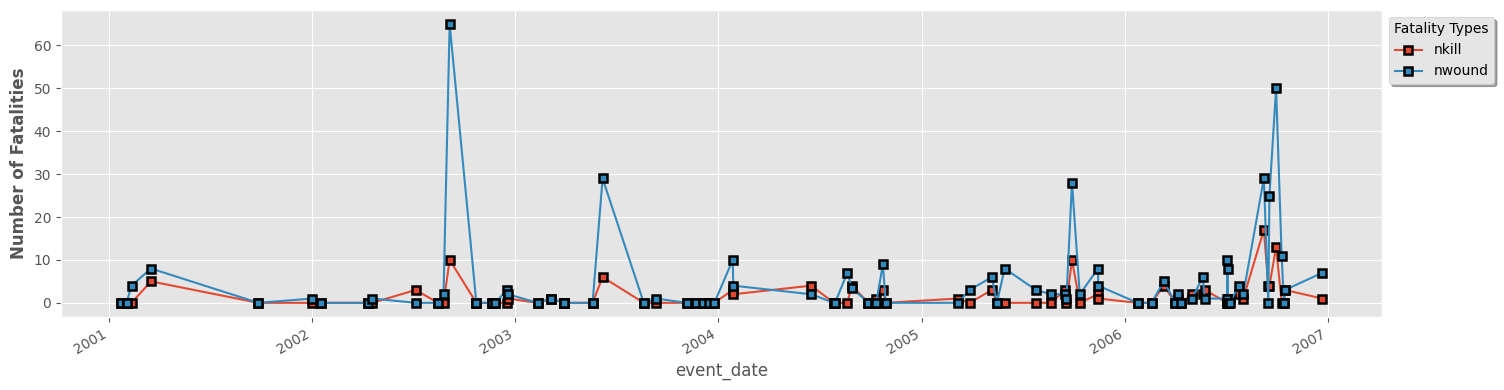

In [122]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot() 
kabul_df.set_index('event_date')[['nkill', 'nwound']].interpolate().plot(ax=ax, marker='s', mec='black', mew=1.8)
ax.legend(title="Fatality Types", fancybox=True, shadow=True, bbox_to_anchor=(1.09,1))
ax.set_ylabel("Number of Fatalities", fontweight='bold')

plt.tight_layout() 

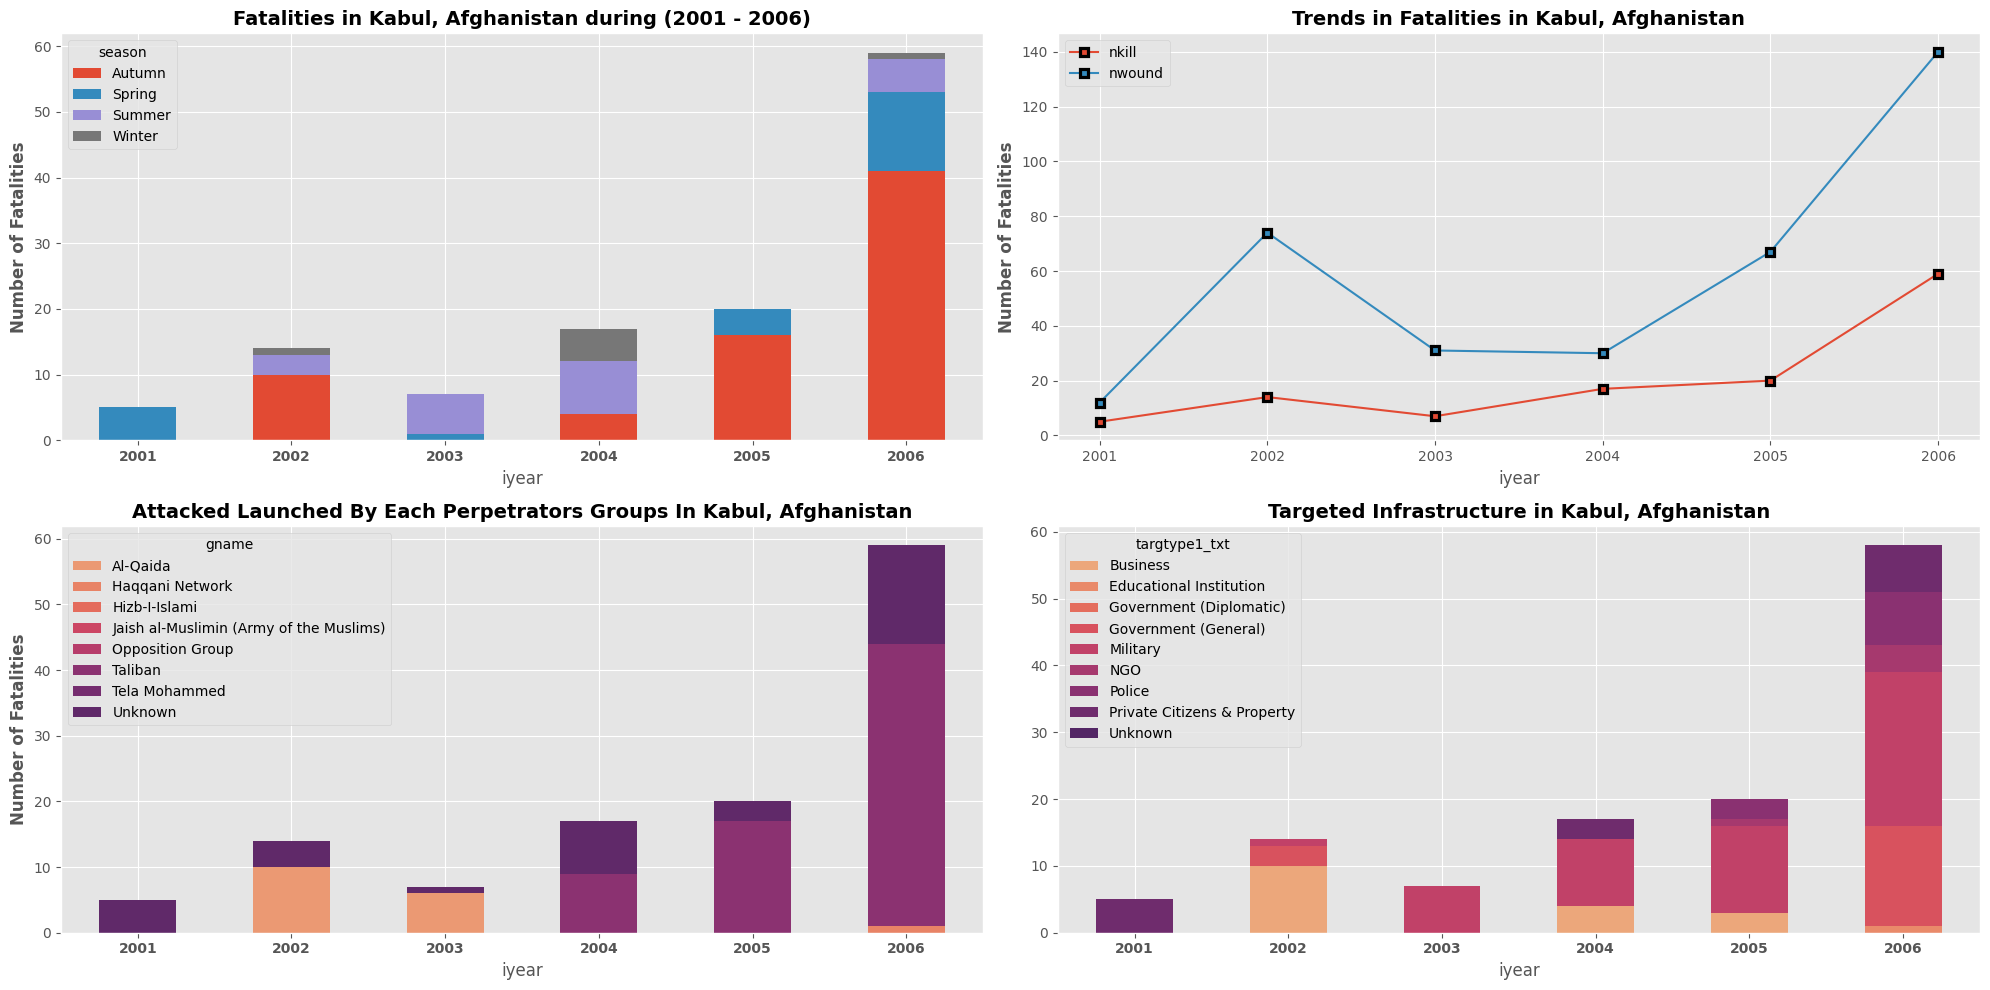

In [84]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(2,2,1)

# fatalities by seasons 
kabul_df.groupby(['iyear', 'season'])['nkill'].sum().unstack('season').replace({np.nan: 0.0}).plot(kind='bar', stacked=True, ax=ax) 
ax.set_title("Fatalities in Kabul, Afghanistan during (2001 - 2006)", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontweight='bold')

# Trends in Fatalities in Kabul, AFG
ax = fig.add_subplot(2,2,2)
kabul_df.groupby('iyear')[['nkill','nwound']].sum().plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Trends in Fatalities in Kabul, Afghanistan", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

ax = fig.add_subplot(2,2,3) 
# attacked launched by each prep groups 
pd.pivot_table(data=kabul_df, index='iyear', columns=['gname'], values='nkill', aggfunc='sum').replace({np.nan:0.0}).astype(int).plot(kind='bar', stacked=True, cmap=ListedColormap(sns.color_palette(palette='flare' , n_colors=10)) , ax=ax)       
ax.set_title("attacked launched by each perpetrators groups in kabul, Afghanistan".title(), fontweight='bold', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontweight='bold')
ax.set_ylabel("Number of Fatalities", fontweight='bold')

ax = fig.add_subplot(2,2,4)
targeted_infra: 'DataFrame' = kabul_df.query("success == 1").groupby(['iyear', 'targtype1_txt'])['nkill'].sum().unstack("targtype1_txt").replace({np.nan:0.0}).astype(int)
targeted_infra.plot(kind='bar', stacked=True, cmap=ListedColormap(sns.color_palette(palette='flare', n_colors=25)), ax=ax)
ax.set_title("Targeted Infrastructure in Kabul, Afghanistan", fontweight='bold', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontweight='bold')

plt.tight_layout() 

## **Number of Successful v.s. Unsuccessful Attack in Kabul Afghanistan (2001 - 2006)** 

In [147]:
kabul_df.groupby(['success', 'gname']).size().unstack('success').replace({np.nan:0.0}).astype(int).rename({1: 'Successful Attack', 0: 'Unsuccessful Attack'}, axis=1)

success,Unsuccessful Attack,Successful Attack
gname,,
Al-Qaida,0,3
Haqqani Network,1,0
Hizb-I-Islami,0,3
Jaish al-Muslimin (Army of the Muslims),0,1
Opposition Group,0,5
Taliban,2,35
Tela Mohammed,0,1
Unknown,5,26


## **Events in Herat**

In [12]:
herat_df: 'DataFrame' = afghan_df.query("provstate == 'Herat'") 
herat_df.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date
9217,197909090001,1979,9,9,NaN,0,NaT,4,Afghanistan,6,South Asia,Herat,Herat,34.346722,62.197315,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,18,...,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,-9,-9,NaN,1979-09-09
36849,198901110013,1989,1,11,NaN,0,NaT,4,Afghanistan,6,South Asia,Herat,Herat,34.346722,62.197315,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,14,...,20.0,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN,1989-01-11
37330,198902210024,1989,2,21,NaN,0,NaT,4,Afghanistan,6,South Asia,Herat,Herat,34.346722,62.197315,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,1,...,6.0,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN,1989-02-21


In [120]:
herat_attacked: 'DataFrame' = pd.pivot_table(data=herat_df, index='iyear', columns=['attacktype1_txt'], values=['nkill'], aggfunc='sum' ).replace({np.nan:0.0})
herat_attacked.columns = [ col[1].strip() for col in herat_attacked.columns.tolist() ]
herat_attacked

,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,Unknown
iyear,,,,,,,,,
1979,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,2.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,2.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2006,4.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,26.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0
2008,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,5.0,1.0,17.0,0.0,0.0,0.0,0.0,0.0,10.0


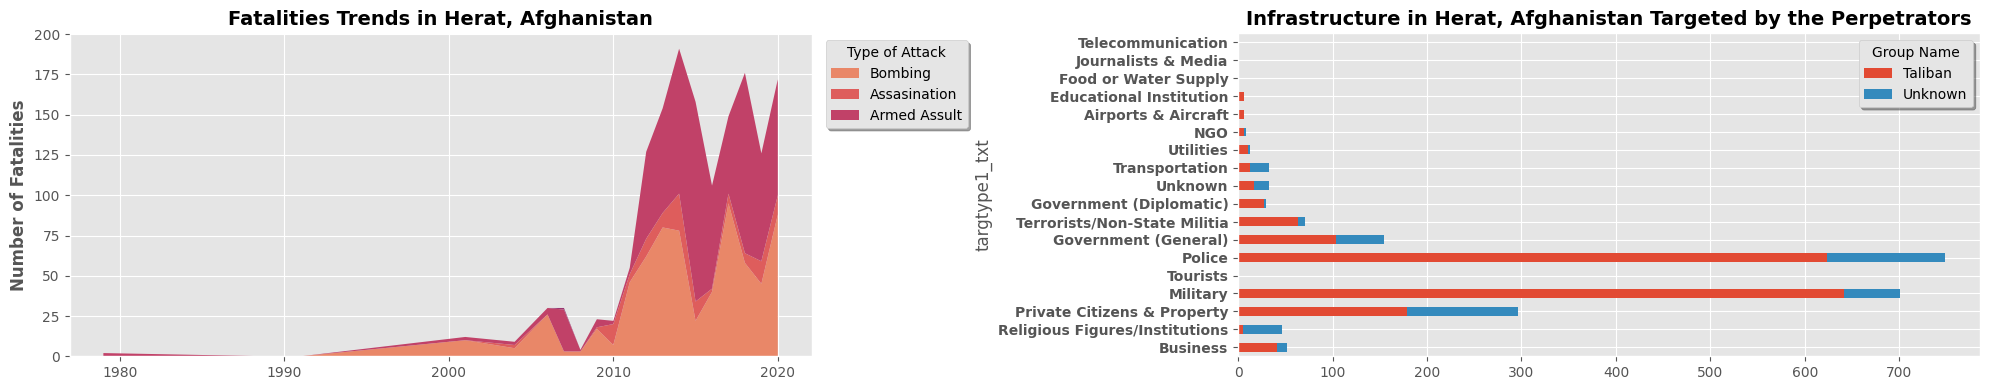

In [93]:
# Herat: Fatality Trends 
fig = plt.figure(figsize=(20,4)) 
ax = fig.add_subplot(1,2,1) 

ax.stackplot(herat_attacked.index.tolist(), 
             herat_attacked['Bombing/Explosion'].tolist(), 
             herat_attacked['Assassination'].tolist(), 
             herat_attacked['Armed Assault'].tolist(), 
             herat_attacked['Facility/Infrastructure Attack'].tolist(), 
             labels=[ 'Bombing', 'Assasination', 'Armed Assult'], colors=sns.color_palette(palette='flare', n_colors=5).as_hex() ) 
ax.set_title("Fatalities Trends in Herat, Afghanistan", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities", fontweight='bold') 
ax.legend(title="Type of Attack", fancybox=True, shadow=True, bbox_to_anchor=(1.22, 1))

# targeted infrastructure in Herat
ax = fig.add_subplot(1,2,2) 
herat_infra: 'DataFrame' = afghan_df.query("provstate == 'Herat' ").groupby(['gname', 'targtype1_txt'])['nkill'].sum().unstack("gname").replace({np.nan:0.0})  
herat_infra.sort_values(by=herat_infra.columns.tolist(), ascending=False ,axis=0 )[['Taliban', 'Unknown']].plot(kind='barh', stacked=True, ax=ax)
ax.set_title("Infrastructure in Herat, Afghanistan Targeted by the Perpetrators", fontweight='bold', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
ax.legend(title="Group Name", fancybox=True, shadow=True)
plt.tight_layout() 

## **Number of Killed and Wounded in Herat and Afghanistan**

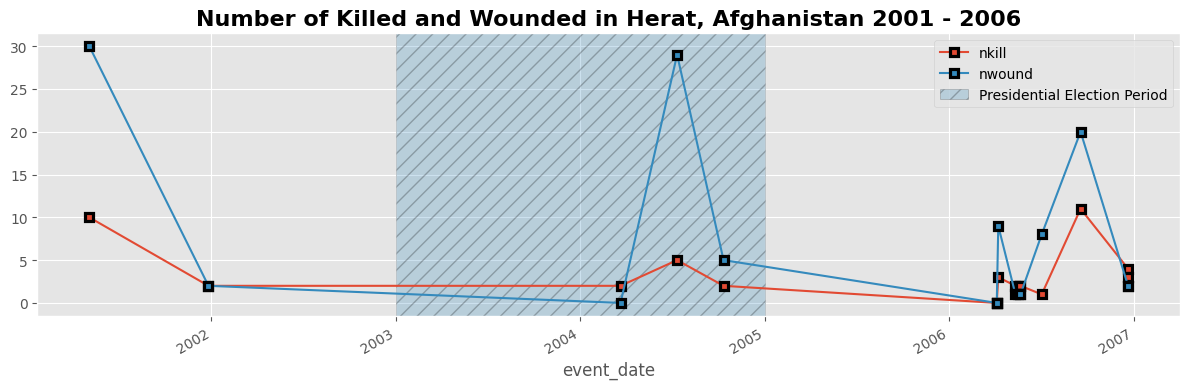

In [158]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot() 
afghan_df.query("provstate == 'Herat' and (iyear > 2000 and iyear < 2007) ").set_index('event_date')[['nkill','nwound']].replace({np.nan:0.0}).plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Number of Killed and Wounded in Herat, Afghanistan 2001 - 2006", fontweight='bold', fontsize=16)
ax.axvspan(xmin=pd.to_datetime("2003-01-01") , xmax=pd.to_datetime("2005-01-01"),  label="Presidential Election Period" , edgecolor='black', hatch="//", alpha=0.25 ) # President Karzai elected (2004), followed by the bloody resurgence 2006 
ax.legend() 
plt.tight_layout() 

## **Events in Mazar-e Sharif** 

In [16]:
mazar_df: 'DataFrame' = afghan_df[ afghan_df['city'].isin( pd.Series(afghan_df['city'].unique().tolist()).astype(str).apply(lambda row: row if re.match(r"^Mazari", row ) else np.nan ).dropna().tolist() ) ]
mazar_df['month_name'] = mazar_df['event_date'].apply(lambda row: row.month_name()) 

## **Additional Information: Haqqani Network Activities in Afghanistan and Pakistan**

In [107]:
central_asia: 'DataFrame' = pd.read_csv( os.path.join(DATASET_PATH, "1900-01-22-2021-11-22-Caucasus_and_Central_Asia-Middle_East-South_Asia.csv"))
results_df: 'DataFrame'  = pd.DataFrame( gdb.query("gname == 'Haqqani Network'")[['country_txt', 'provstate']].value_counts()).rename({'count': 'Fatalities' }, axis=1) # Haqqani Network: (Supported by the Pakistani Army)
results_df1: 'DataFrame' = pd.DataFrame( central_asia[ central_asia['actor1'].apply(lambda row: 'haqqani' in row.lower()) ].groupby(['country', 'admin1'])['fatalities'].sum()).rename({'fatalities': 'Fatalities'}, axis=1)

visited: set = set() 
results: set = set() 
for row in results_df1.iterrows():
    for row1 in results_df.iterrows(): 
        if row[0] == row1[0]: 
            location: str = "%s, %s" % (row[0][1], row[0][0])
            results.add( ( location , row[1][0] + row1[1][0] ) )
            visited.add(location) 

combined_fatalities: List[tuple] = [ ( "%s, %s" % (row[0][1], row[0][0] ), row[1][0] ) for row in results_df1.iterrows() if "%s, %s" % (row[0][1], row[0][0] ) not in visited ] +\
                                   [ ( "%s, %s" % (row[0][1], row[0][0] ), row[1][0] ) for row in results_df.iterrows() if "%s, %s" % (row[0][1], row[0][0] ) not in visited ] +\
                                   list(results ) 


pd.DataFrame(list(map(lambda item:item[1], combined_fatalities)) , index=list(map(lambda item:item[0], combined_fatalities)), columns=['Fatalities']  ).sort_values(by='Fatalities', ascending=False) 

,Fatalities
"Kabul, Afghanistan",45
"Khost, Afghanistan",22
"Kandahar, Afghanistan",14
"Nangarhar, Afghanistan",10
"Logar, Afghanistan",7
"Paktika, Afghanistan",7
"Paktia, Afghanistan",4
"Wardak, Afghanistan",3
"Kunduz, Afghanistan",2
"FATA, Pakistan",1


### **Haqqani Network: Fatalities and Events**

In [55]:
pd.DataFrame( central_asia[ central_asia['actor1'].apply(lambda row: 'haqqani' in row.lower()) ].groupby( ['country', 'admin1', 'event_type'])[ 'fatalities' ].sum())

fatalities
country     admin1    event_type                            
Afghanistan Kabul     Violence against civilians           1
            Kandahar  Explosions/Remote violence          12
            Khost     Battles                              2
                      Strategic developments               8
            Nangarhar Battles                              6
Pakistan    FATA      Battles                              1

## **Correlations between Variables**

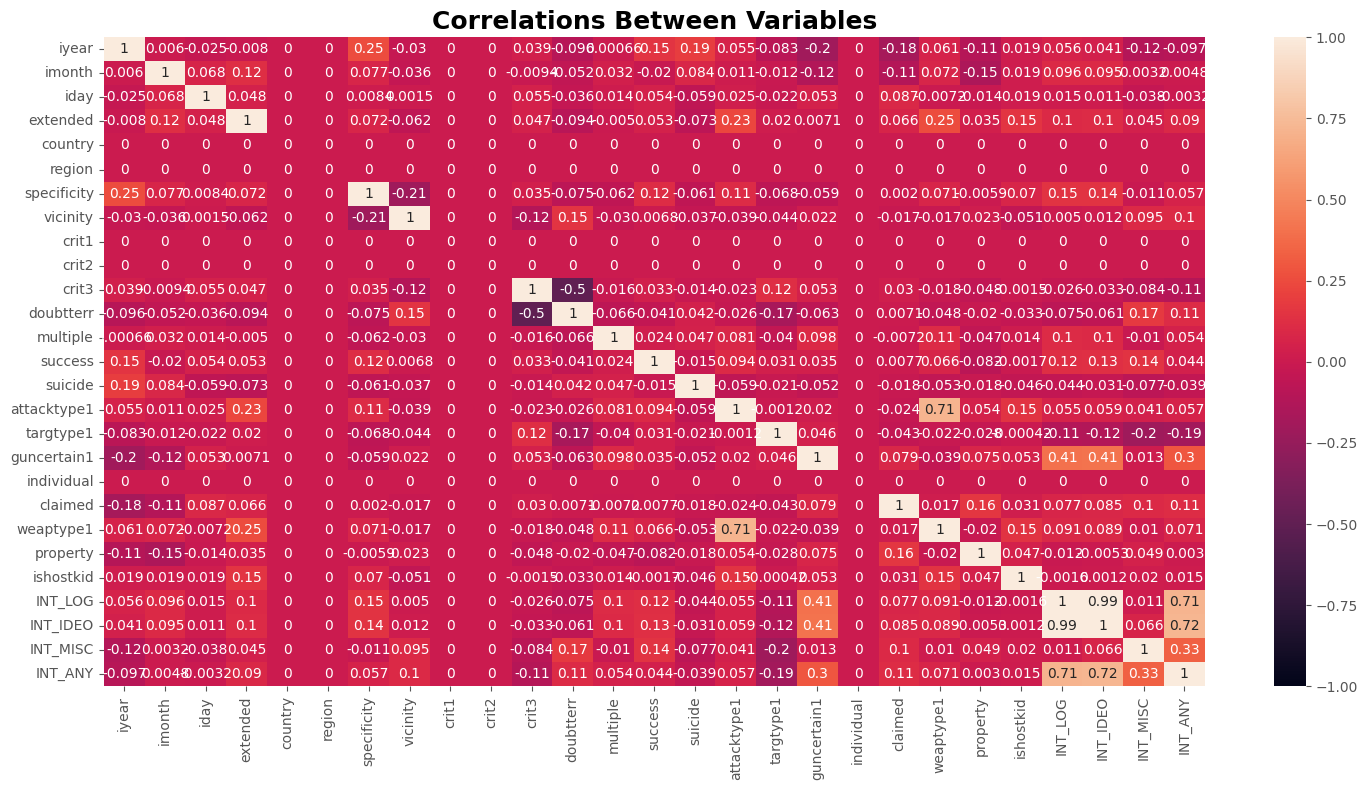

In [186]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot() 
sns.heatmap(salvo_df[salvo_df.dtypes.apply(lambda row: str(row) == 'int64' ).replace({False: np.nan} ).dropna().index.tolist()[2:] ].corr().replace({np.nan:0.0} ), annot=True, ax=ax, vmin=-1, vmax=1 )
ax.set_title("Correlations Between Variables", fontweight='bold', fontsize=18)
plt.tight_layout() 

## **Linear Relationship between Variables**
- Group Names and Fatalities

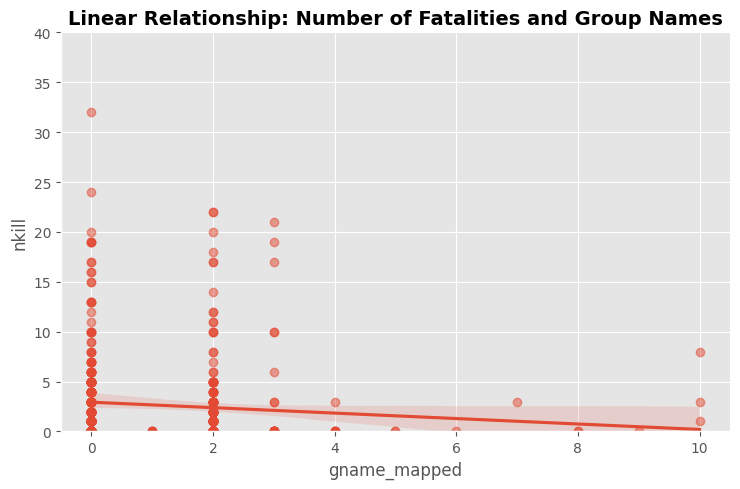

In [149]:
sns.lmplot(data=salvo_df, x='gname_mapped', y='nkill', aspect=1.5, scatter_kws={'alpha': 0.5})
plt.title("Linear Relationship: Number of Fatalities and Group Names", fontweight='bold', fontsize=14)
plt.ylim([0, 40] )
plt.tight_layout() 

- Target Types and Fatalties 

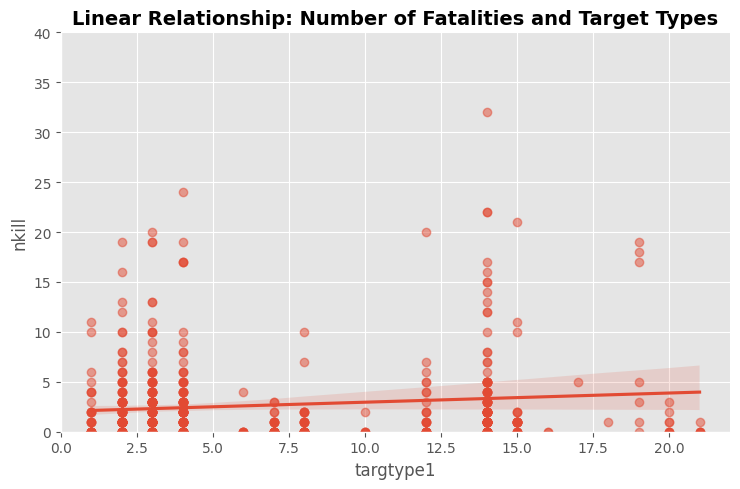

In [150]:
sns.lmplot(data=salvo_df, x='targtype1', y='nkill', aspect=1.5, scatter_kws={'alpha': 0.5})
plt.title("Linear Relationship: Number of Fatalities and Target Types", fontweight='bold', fontsize=14)
plt.ylim([0, 40] )
plt.tight_layout() 

- Month and Fatalties 

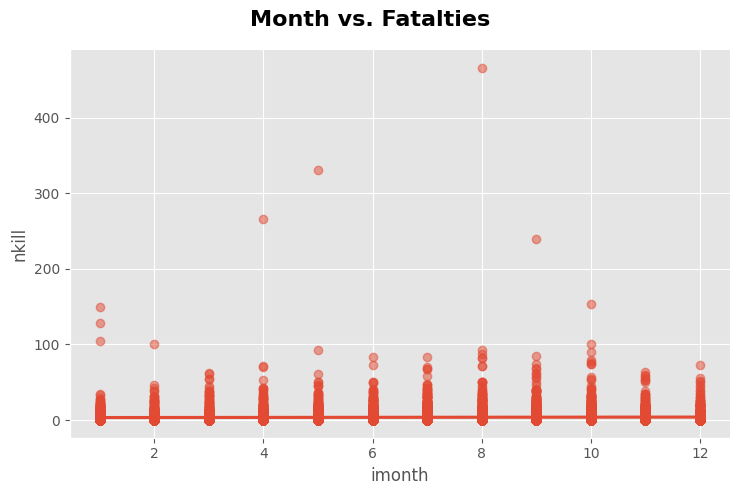

In [254]:
ax = sns.lmplot(data=afghan_df, x='imonth', y='nkill', aspect=1.5, scatter_kws={'alpha':0.5} ) 
ax.fig.suptitle("Month vs. Fatalties", fontweight='bold', fontsize=16 ) 

plt.tight_layout() 

## **Simple Linear Regression Analysis** 
1. **Model One**: `Number of Fatalities` and `Month`

In [267]:
model_one: 'OLS' = sm.OLS(afghan_df['nkill'].replace({np.nan:0.0} ) , afghan_df['imonth'].replace({np.nan:0.0} ) ).fit() 
model_one.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  nkill   R-squared (uncentered):                   0.135
Model:                            OLS   Adj. R-squared (uncentered):              0.135
Method:                 Least Squares   F-statistic:                              2965.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):                        0.00
Time:                        16:05:47   Log-Likelihood:                         -66967.
No. Observations:               18920   AIC:                                  1.339e+05
Df Residuals:                   18919   BIC:                                  1.339e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
imonth         0.4441      0.008     54.453      0.000       0.428       0.460
==============================================================================
Omnibus:                    40314.802   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        439036093.569
Skew:                          18.388   Prob(JB):                         0.00
Kurtosis:                     748.362   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

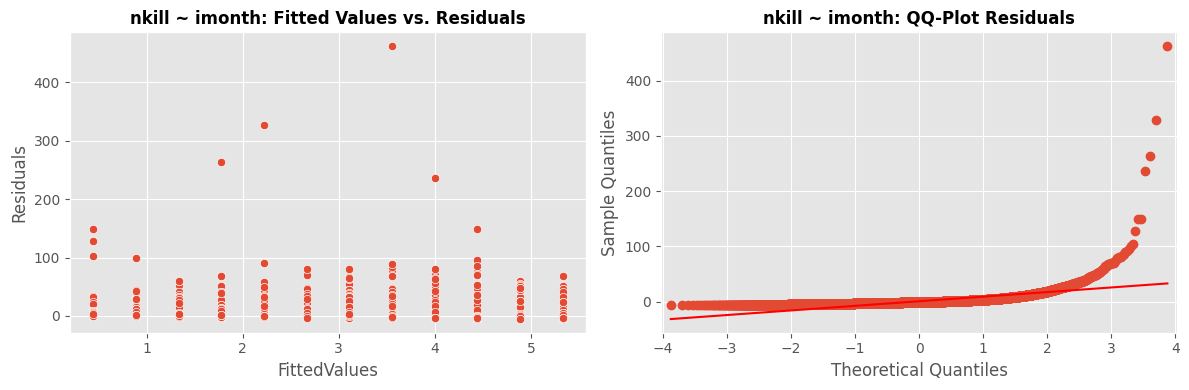

In [294]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,2,1)

sns.scatterplot(data=pd.DataFrame({'FittedValues': model_one.fittedvalues.tolist(), 'Residuals': model_one.resid.tolist()} ), x='FittedValues', y='Residuals' , ax=ax)
ax.set_title("nkill ~ imonth: Fitted Values vs. Residuals", fontweight='bold', fontsize=12)

ax = fig.add_subplot(1,2,2)
sm.qqplot(model_one.resid, ax=ax, line='s') 
ax.set_title("nkill ~ imonth: QQ-Plot Residuals", fontweight='bold', fontsize=12)
plt.tight_layout() 

2. **Model Two**: `Number of Fatalities` and `Attacked Types` 

In [285]:
model_two: 'OLS' = sm.OLS(afghan_df['nkill'].replace({np.nan:0.0}), afghan_df['attacktype1']).fit()
model_two.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  nkill   R-squared (uncentered):                   0.128
Model:                            OLS   Adj. R-squared (uncentered):              0.128
Method:                 Least Squares   F-statistic:                              2780.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):                        0.00
Time:                        16:22:23   Log-Likelihood:                         -67047.
No. Observations:               18920   AIC:                                  1.341e+05
Df Residuals:                   18919   BIC:                                  1.341e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
attacktype1     0.6690      0.013     52.729      0.000       0.644       0.694
==============================================================================
Omnibus:                    40362.526   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        442818100.280
Skew:                          18.438   Prob(JB):                         0.00
Kurtosis:                     751.568   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

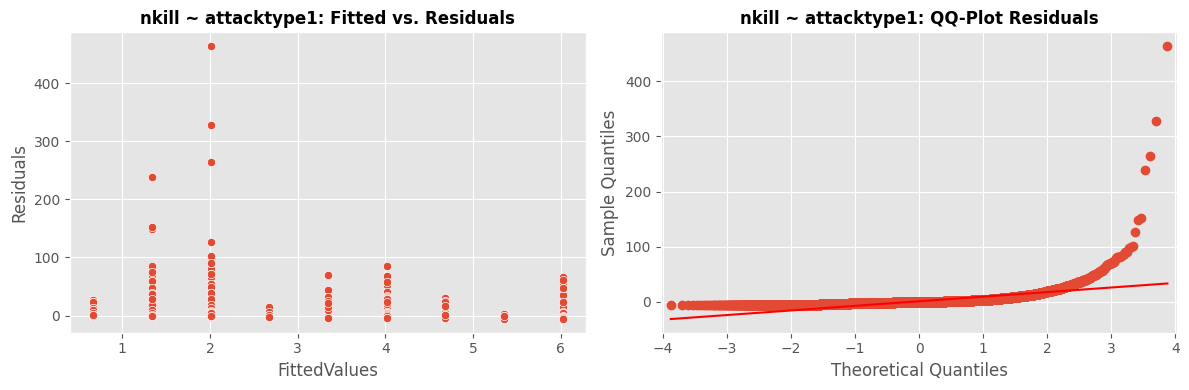

In [300]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,2,1) 
sns.scatterplot(data=pd.DataFrame( { 'FittedValues': model_two.fittedvalues.tolist() , 'Residuals': model_two.resid.tolist() }), x='FittedValues', y='Residuals' )
ax.set_title("nkill ~ attacktype1: Fitted vs. Residuals", fontweight='bold', fontsize=12 )

ax = fig.add_subplot(1,2,2)
sm.qqplot(model_two.resid, line='s', ax=ax)
ax.set_title("nkill ~ attacktype1: QQ-Plot Residuals", fontweight='bold', fontsize=12)

plt.tight_layout() 

# **Predicting Fatalties Based on Models**
- **Model 1**: `Target Types`, `Month`, `Weapons`, `Attack Types`


In [4]:
feature_columns: List[str] = ['weaptype1', 'targtype1', 'attacktype1']
months: 'DataFrame' = pd.get_dummies(afghan_df['imonth']).rename({ month:pd.to_datetime(  "2023-%s-01" % (month) ).month_name() for month in range(1,13) } , axis=1).replace({True:1, False:0}).iloc[:,1:]
X: 'DataFrame' = afghan_df[feature_columns]
X = pd.concat([X, months], axis=1)
y: 'Series' = afghan_df['nkill'].replace({np.nan:0.0})

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)
y_null: 'Series' = [y_test.mean()] * y_test.shape[0] # always predict the mean fatalities 
linreg: LinearRegression = LinearRegression()

- **Model 2**: `Target Types`, `Attack Types`, `Weapon Types`, `Month`

In [5]:
afghan_df['provstate_mapped'] = pd.factorize(afghan_df['provstate'])[0]
afghan_df['gname_mapped'] = pd.factorize(afghan_df['gname'])[0]
feature_columns: List[str] = ['weaptype1', 'targtype1', 'attacktype1', 'provstate_mapped', 'gname_mapped']
X2_train,X2_test,y2_train,y2_test = train_test_split(afghan_df[feature_columns], y)

- **Model 3**: `Target Types`, `Attack Types`, `Weapon Types`, `Month`, `Number of Perpetrators` 

In [32]:
feature_columns: List[str] = ['weaptype1', 'targtype1', 'attacktype1', 'provstate_mapped', 'gname_mapped', 'nperps']
afghan_df['nperps'] = afghan_df['nperps'].replace({np.nan:0.0, -99.0:0.0})
X3_train,X3_test,y3_train,y3_test = train_test_split(afghan_df[feature_columns], y, random_state=100)
model_three = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(len(feature_columns), )),
                                   tf.keras.layers.Dense(32, activation='relu'),  # hidden layers 
                                   tf.keras.layers.Dropout(0.2), 
                                   tf.keras.layers.BatchNormalization(), 
                                   tf.keras.layers.Dense(16, activation='relu'), 
                                   tf.keras.layers.Dense(1) 
                                  ])

model_three.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model_three.fit(X3_train, y3_train, epochs=50, batch_size=32, validation_data=(X3_test,y3_test)) 
model_three_rmse: float = np.sqrt( metrics.mean_squared_error(y_true=y3_test, y_pred=model_three.predict(X3_test) ))

Epoch 1/50
444/444 [==============================] - 3s 3ms/step - loss: 72.8563 - mean_absolute_error: 3.4009 - val_loss: 48.9289 - val_mean_absolute_error: 3.0745
Epoch 2/50
444/444 [==============================] - 1s 3ms/step - loss: 70.9572 - mean_absolute_error: 3.4818 - val_loss: 47.2466 - val_mean_absolute_error: 3.2128
Epoch 3/50
444/444 [==============================] - 1s 3ms/step - loss: 70.7139 - mean_absolute_error: 3.4883 - val_loss: 48.4422 - val_mean_absolute_error: 3.1748
Epoch 4/50
444/444 [==============================] - 1s 3ms/step - loss: 70.0965 - mean_absolute_error: 3.4750 - val_loss: 47.5899 - val_mean_absolute_error: 3.0976
Epoch 5/50
444/444 [==============================] - 2s 3ms/step - loss: 69.4988 - mean_absolute_error: 3.4579 - val_loss: 46.4989 - val_mean_absolute_error: 3.1203
Epoch 6/50
444/444 [==============================] - 1s 3ms/step - loss: 69.7810 - mean_absolute_error: 3.4613 - val_loss: 46.7467 - val_mean_absolute_error: 3.1523
Epoc

## **Model 3 Overfitting Test**

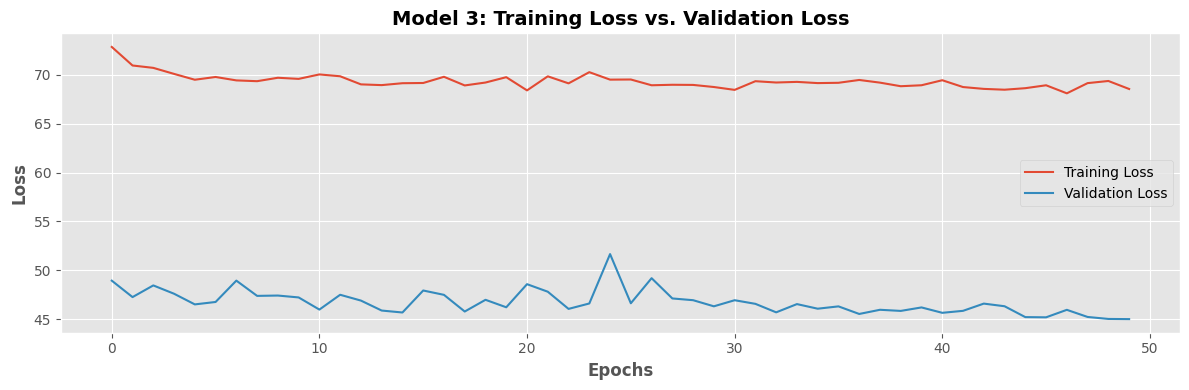

In [39]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot()
pd.DataFrame( {'Training Loss': history.history.get('loss'), 'Validation Loss': history.history.get('val_loss') }).plot(ax=ax)
ax.set_title("Model 3: Training Loss vs. Validation Loss", fontweight='bold', fontsize=14)
ax.set_xlabel("Epochs", fontweight='bold')
ax.set_ylabel("Loss" , fontweight='bold')
plt.tight_layout()

## **Modeling Fatalities using Neural Network (Model 3)** 
### **Scenario**:
1. Unkown number of perps
2. Weapon Types Firearms
3. Target Government Building
4. Province `Kapisa`
5. Perps `Lashkar-e-Islam (Pakistan)`

- Known Perpetrators in `AFG`

In [65]:
pd.DataFrame(dict(zip( pd.factorize(afghan_df['gname'])[0].tolist() ,  pd.factorize(afghan_df['gname'])[1].tolist())), index=['gname'] ).transpose() 

,gname
0,Black December
1,Shia Muslim extremists
2,Afghan Mujahideen
3,Khorasan Chapter of the Islamic State
4,Harakat-i-Inqilahi-i-Islami
5,Lashkar-e-Islam (Pakistan)
6,Muslim extremists
7,Militants
8,Gunmen
9,Jaish-e-Mohammad (JeM)


- `AFG Provstate`

In [64]:
pd.DataFrame(dict(zip( pd.factorize(afghan_df['provstate'])[0].tolist() ,  pd.factorize(afghan_df['provstate'])[1].tolist())), index=['provstate'] ).transpose() 

,provstate
0,Kapisa
1,Herat
2,Jawzjan
3,Paktika Province
4,Kandahar
5,Sari Pul
6,Baghlan
7,Nuristan
8,Panjsher


In [76]:
scenario: 'DataFrame' = pd.DataFrame({'weaptype1':5, 'targtype1':2, 'attacktype1':6, 'provstate_mapped':0,  'gname_mapped':5 , 'nperps':0.0}, index=[1]) # npers = 0 (Unknown) 
fatalities: int = round(model_three.predict(scenario).tolist()[0][0])
scenario['n_fatalities'] = fatalities 
scenario

1/1 [==============================] - 0s 22ms/step


,weaptype1,targtype1,attacktype1,provstate_mapped,gname_mapped,nperps,n_fatalities
1,5,2,6,0,5,0.0,2


## **Model Evaluation: RMSE Scores**

In [40]:
results_df: 'DataFrame' = pd.DataFrame( {'Model 1':-1 * cross_val_score(estimator=linreg, X=X_train, y=y_train, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error').mean(),
                                         'Model 2': -1 * cross_val_score(estimator=linreg, X=X2_train, y=y2_train, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error').mean(),
                                         'Model 3': model_three_rmse,
                                         'Null': np.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=y_null))
                                        }, index=['RMSE'])
results_df.transpose() 

,RMSE
Model 1,8.006509
Model 2,8.498905
Model 3,6.707626
Null,7.031872


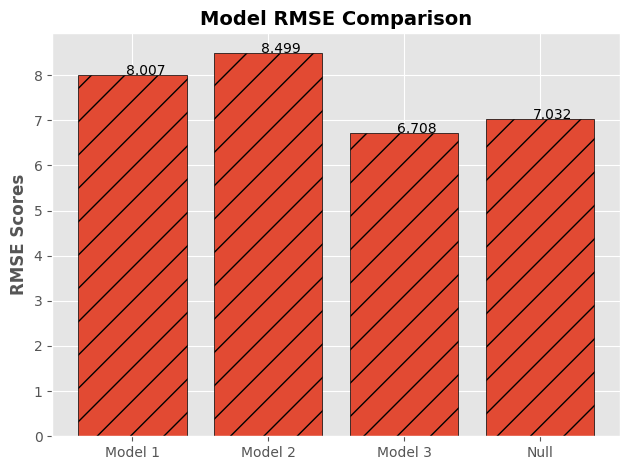

In [54]:
model_names, rmse_scores = zip(*results_df.transpose().to_dict().get('RMSE').items())

fig = plt.figure() 
ax = fig.add_subplot() 
ax.bar(x=list(model_names), height=list(rmse_scores), edgecolor='k', hatch='/')
ax.set_title("Model RMSE Comparison", fontweight='bold', fontsize=14)
ax.set_ylabel("RMSE Scores", fontweight='bold')
for index,val in enumerate(rmse_scores): 
    ax.annotate(text=f"{val:.3f}", xy=(index - 0.05, val))
plt.tight_layout() 